In [1]:
import sys, os, pickle
from joblib import Parallel, delayed
import pandas as pd
from jumpmodels.utils import filter_date_range
from jumpmodels.preprocess import StandardScalerPD, DataClipperStd
from jumpmodels.sparse_jump import SparseJumpModel
from sklearn.preprocessing import StandardScaler
from pypfopt.black_litterman import BlackLittermanModel, market_implied_prior_returns
from pypfopt.efficient_frontier import EfficientFrontier
import numpy as np
import matplotlib.pyplot as plt
from pypfopt import exceptions 
from scipy.optimize import brentq
import cvxpy as cp
from scipy import stats

#sys.path.append('/Users/victor/Documents/thesis_vri_vp/vic_new')         # for mac
sys.path.append('C:\\Users\\victo\\git_new\\thesis_vri_vp\\vic_new')      # for windows
# sys.path.append('/Users/vlad/Desktop/git/Masters-Thesis-VRI-VP/vic_new')         # for mac vlad
from feature_set_v2 import MergedDataLoader 

In [2]:
# 0) Global parameters ------------------------------------------------------------------
REFIT_FREQ        = "ME"        
MIN_TRAINING_YEARS= 8
MAX_TRAINING_YEARS= 12
INITIAL_TRAIN_START = "2002-05-31"
test_start        = "2017-01-01"

# Pick method to drive backtest: "grid", "bayes" or "history" ---------------------------
cv_choice = "bayes"

# Paths & tickers -----------------------------------------------------------------------
script_dir = os.getcwd()
base_dir   = os.path.abspath(os.path.join(script_dir, "..", "..", "..","..", "..",".."))
data_dir   = os.path.join(base_dir, "data_new")

factor_file = os.path.join(data_dir, "1estimation_index_returns.csv")
market_file = os.path.join(data_dir, "1macro_data.csv")
etf_file    = os.path.join(data_dir, "2trading_etf_returns_aligned.csv")

factors = ["iwf", "mtum", "qual", "size", "usmv", "vlue"]   # used everywhere

# grid_df    = pd.read_parquet("cv_params_grid.parquet")
# bayes_df   = pd.read_parquet("cv_params_bayes_v2.parquet") # v2 is the one searching between 20-2000
# history_df = pd.read_parquet("cv_params_history.parquet")

In [3]:
# # ──────────────────────────────────────────────────────────────
# # HYPERPARAMETERS
# # ──────────────────────────────────────────────────────────────
# df_map = {
#     "grid":    grid_df,
#     "bayes":   bayes_df,
#     "history": history_df
# }
# cv_df = df_map[cv_choice]

# # ─────────────────────────────────────────────────────
# # HYPERPARAMETER SMOOTHING SETUP
# # ─────────────────────────────────────────────────────
# # pick one
# SMOOTH_METHOD = "none"   # options: "none", "rolling_median", "ewma"
# SMOOTH_WINDOW = 3        # # of folds to include in the window
# # ─────────────────────────────────────────────────────

# # … right after cv_df = df_map[cv_choice] …
# cv_df = cv_df.sort_values(["factor","date"])

# if SMOOTH_METHOD == "none":
#     # simply copy original λ & κ forward
#     cv_df["sm_lambda"] = cv_df["best_lambda"]
#     cv_df["sm_kappa"]  = cv_df["best_kappa"]

# elif SMOOTH_METHOD == "rolling_median":
#     # Centered rolling median
#     cv_df["sm_lambda"] = (
#         cv_df
#         .groupby("factor")["best_lambda"]
#         .transform(lambda x: x.rolling(SMOOTH_WINDOW, min_periods=1, center=True).median())
#     )
#     cv_df["sm_kappa"] = (
#         cv_df
#         .groupby("factor")["best_kappa"]
#         .transform(lambda x: x.rolling(SMOOTH_WINDOW, min_periods=1, center=True).median())
#     )

# elif SMOOTH_METHOD == "ewma":
#     # Exponential‐weight moving average
#     cv_df["sm_lambda"] = (
#         cv_df
#         .groupby("factor")["best_lambda"]
#         .transform(lambda x: x.ewm(span=SMOOTH_WINDOW, min_periods=1).mean())
#     )
#     cv_df["sm_kappa"] = (
#         cv_df
#         .groupby("factor")["best_kappa"]
#         .transform(lambda x: x.ewm(span=SMOOTH_WINDOW, min_periods=1).mean())
#     )

# else:
#     raise ValueError(f"Unknown SMOOTH_METHOD {SMOOTH_METHOD!r}")

# # round κ back to integer
# cv_df["sm_kappa"] = cv_df["sm_kappa"].round().astype(int)

# # overwrite with the chosen values
# cv_df["best_lambda"] = cv_df["sm_lambda"]
# cv_df["best_kappa"]  = cv_df["sm_kappa"]

# # (optional) drop helpers
# cv_df.drop(columns=["sm_lambda","sm_kappa"], inplace=True)

# # ─────────────────────────────────────────────────────
# # Now build saved_hyperparams exactly as before
# # ─────────────────────────────────────────────────────
# saved_hyperparams = {}
# for fac in factors:
#     sub = cv_df[cv_df["factor"] == fac].sort_values("date")
#     saved_hyperparams[fac] = [
#         {
#             "date":      row["date"],
#             "new_lambda": row["best_lambda"],
#             "new_kappa":  row["best_kappa"]
#         }
#         for _, row in sub.iterrows()
#     ]


In [4]:
# ──────────────────────────────────────────────────────────────
# DATA‑LOADING BLOCK  (pulled from old notebook)
# ──────────────────────────────────────────────────────────────

# 1) Load full data for every factor + market ------------------------------------------------
factor_data_dict  = {}
factor_returns_ls = []

for fac in factors:
    print(f"Loading data for {fac}")
    data = MergedDataLoader(
        factor_file=factor_file,
        market_file=market_file,
        ver="v2",
        factor_col=fac
    ).load()

    common_idx = (data.X.index
                  .intersection(data.ret_ser.index)
                  .intersection(data.market_ser.index))

    X_full        = data.X.loc[common_idx]
    fac_ret_full  = data.ret_ser.loc[common_idx]
    mkt_ret_full  = data.market_ser.loc[common_idx]
    active_ret    = fac_ret_full - mkt_ret_full

    factor_data_dict[fac] = {
        "X"        : X_full,
        "fac_ret"  : fac_ret_full,
        "mkt_ret"  : mkt_ret_full,
        "active_ret": active_ret,
    }
    factor_returns_ls.append(fac_ret_full)

# save last loop’s mkt_ret_full as market series
all_market_ret = mkt_ret_full

# 2) Assemble master return dataframe (factors + Market + rf) -------------------------------
full_factors_df = pd.concat(factor_returns_ls, axis=1).dropna()
full_df = pd.concat([full_factors_df, all_market_ret], axis=1).dropna()
full_df.columns = factors + ["Market"]

# risk‑free
etf_df   = pd.read_csv(etf_file, index_col=0, parse_dates=True).dropna().sort_index()
rf_ser   = etf_df["rf"]
full_df  = pd.concat([full_df, rf_ser], axis=1).dropna()
full_df.columns = factors + ["Market", "rf"]

# 3) Define test index (everything from 2017‑01‑01 on) --------------------------------------
test_slice = full_df.loc[test_start:]
test_index = test_slice.index.sort_values()
# ──────────────────────────────────────────────────────────────


Loading data for iwf
Loading data for mtum
Loading data for qual
Loading data for size
Loading data for usmv
Loading data for vlue


In [5]:
# ------------------------------------------------------------
# 1  BUILD & CACHE FACTOR‑VIEWS  (run once, takes minutes)
# ------------------------------------------------------------
VIEWS_FILE = "bayes_factor_views_v2_2014.pkl" # "SAVEfactor_views.pkl" is the views for the outperforming sharpe run
FORCE_REBUILD = False 

def _fit_one_factor(fac, refit_date, test_dates_chunk,
                    factor_data_dict, hyperparams,
                    min_years, max_years, init_start):

    # ---------- helpers ----------
    def get_train_window(current_date, full_data):
        train_end  = current_date
        train_start= max(train_end - pd.DateOffset(years=max_years),
                         pd.to_datetime(init_start))
        if (train_end - train_start) < pd.Timedelta(days=365.25*min_years):
            train_start = train_end - pd.DateOffset(years=min_years)
        idx = full_data.index
        subset = idx[(idx >= train_start) & (idx <= train_end)]
        start_date, end_date = subset.min(), subset.max()
        return start_date, end_date 

    # ---------- data ----------
    fac_data = factor_data_dict[fac]
    X   = fac_data["X"]
    ret = fac_data["fac_ret"]
    act = fac_data["active_ret"]

    lam = hyperparams["new_lambda"]
    kp  = hyperparams["new_kappa"]
    train_start, train_end = get_train_window(refit_date, X)

    # ---------- preprocess ----------
    clipper = DataClipperStd(mul=3.0)
    scaler  = StandardScaler()
    X_train = scaler.fit_transform(clipper.fit_transform(
                 filter_date_range(X, train_start, train_end)))
    active_train = filter_date_range(act, train_start, train_end)

    # ---------- fit SJM ----------
    sjm = SparseJumpModel(n_components=2,
                          max_feats=int(kp**2),
                          jump_penalty=lam)
    
    train_idx = filter_date_range(X, train_start, train_end).index
    X_train_df = pd.DataFrame(X_train, index=train_idx, columns=X.columns)
    sjm.fit(X_train_df, ret_ser=active_train, sort_by="cumret")

    ret_train = filter_date_range(ret, train_start, train_end)

    # regime‑level abs returns
    train_states = sjm.predict(X_train_df)
    abs_ret = {}
    for st in range(2):
        st_idx = (train_states==st)
        abs_ret[st] = ret_train.loc[st_idx].mean() * 252

    # ---------- online prediction for test dates ----------
    states = {}
    for day in test_dates_chunk:
        X_hist = X.loc[:day]                          # all history up to 'day'
        temp_clipper = DataClipperStd(mul=3.0)
        X_hist_clip  = temp_clipper.fit_transform(X_hist)

        temp_scaler  = StandardScaler()
        _ = temp_scaler.fit_transform(X_hist_clip)    # fit on *all* history

        if day in X.index:
            X_day_clip   = temp_clipper.transform(X.loc[[day]])
            X_day_scaled = temp_scaler.transform(X_day_clip)
            states[day]  = sjm.predict_online(
                pd.DataFrame(X_day_scaled,
                            index=[day],
                            columns=X.columns)).iloc[0]

    # assemble mini‑df for this factor & period
    out = pd.DataFrame({"state": pd.Series(states)},
                       index=list(states.keys()))
    out["ann_abs_ret"] = out["state"].map(abs_ret)
    return fac, out

def build_factor_views(factor_data_dict, saved_hyperparams, factors,
                       test_index,
                       refit_freq="ME", min_years=8, max_years=12,
                       init_start="2002-05-31"):

    views = {f:[] for f in factors}
    refit_dates = (test_index.to_series()
                   .resample(refit_freq)
                   .last()
                   .dropna())

    for j, refit_date in enumerate(refit_dates):
        if j < len(refit_dates)-1:
            next_refit = refit_dates.iloc[j+1]
        else:
            next_refit = test_index[-1]
        test_mask = (test_index>refit_date)&(test_index<=next_refit)
        test_chunk = test_index[test_mask]

        # ---- parallel over factors ----
        jobs = []
        for fac in factors:
            # latest hyperparams before refit_date
            hp_hist = [h for h in saved_hyperparams[fac]
                       if pd.to_datetime(h["date"])<=refit_date]
            if not hp_hist: continue
            hp = hp_hist[-1]
            jobs.append(delayed(_fit_one_factor)(
                fac, refit_date, test_chunk,
                factor_data_dict, hp,
                min_years, max_years, init_start))
        for fac, df in Parallel(n_jobs=-1)(jobs):
            views[fac].append(df)

    # concat & tidy
    for fac in factors:
        views[fac] = (pd.concat(views[fac])
                      .sort_index()
                      .loc[:,["state","ann_abs_ret"]])
    return views


# --------- build or load ----------         
if FORCE_REBUILD or not os.path.exists(VIEWS_FILE):
    factor_views = build_factor_views(factor_data_dict, saved_hyperparams, factors, 
                                      test_index,
                                      refit_freq=REFIT_FREQ, 
                                      min_years=8, max_years=12, init_start="2002-05-31")
    with open(VIEWS_FILE, "wb") as f:
        pickle.dump(factor_views, f)
else:
    with open(VIEWS_FILE, "rb") as f:
        factor_views = pickle.load(f)



In [6]:
for fac in factor_views:
    # 1) pull & sort your raw active return series
    daily_active = factor_data_dict[fac]["active_ret"].sort_index()

    # 2) build the expanding mean → annualized
    cum_mean_annual = daily_active.expanding().mean() * 252

    # 3) stick the raw active_ret into your factor_views DF
    factor_views[fac]["active_ret"] = (
        cum_mean_annual
        .reindex(factor_views[fac].index, method="ffill")
    )


In [7]:
# import matplotlib.pyplot as plt
# import matplotlib.dates as mdates
# import math

# facs = list(factor_views.keys())
# n, cols = len(facs), 3
# rows = math.ceil(n/cols)

# fig, axes = plt.subplots(rows, cols,
#                          figsize=(cols*4, rows*3.5),
#                          sharex=True, sharey=True)

# for ax, fac in zip(axes.flatten(), facs):
#     df = factor_views[fac]
#     for state, col, lbl in zip(
#         [0,1], ['tab:blue','tab:orange'], ['state 0','state 1']
#     ):
#         sel = df['state'].eq(state)
#         ax.plot(df.index[sel], df.loc[sel,'active_ret'],
#                 color=col, lw=1.5, label=lbl)
#     ax.set_title(fac.upper(), fontsize=12)
#     ax.set_ylim(-0.03, 0.05)
#     ax.grid(alpha=0.25)
#     ax.xaxis.set_major_locator(mdates.YearLocator())
#     ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# # rotate & align all x-labels    
# for ax in axes.flatten():
#     plt.setp(ax.xaxis.get_majorticklabels(),
#              rotation=45, ha='right', fontsize=8)

# # drop unused subplots
# for ax in axes.flatten()[n:]:
#     fig.delaxes(ax)

# # single legend below
# handles, labels = axes.flatten()[0].get_legend_handles_labels()
# fig.legend(handles, labels,
#            loc='lower center',
#            ncol=2, frameon=False, fontsize=10)

# fig.suptitle('Annualized Absolute Return by Regime', fontsize=14, y=1.02)
# fig.tight_layout(rect=[0, 0.05, 1, 0.95])
# plt.show()


In [8]:
# ------------------------------------------------------------
# 2  FAST BLACK‑LITTERMAN FUNCTION  (run as often as you like)
# ------------------------------------------------------------

def ewm_covariance(returns, halflife=126, min_periods=60):
    ewm_cov = returns.ewm(halflife=halflife,
                          adjust=False,
                          min_periods=min_periods).cov()
    if returns.empty: return pd.DataFrame()
    return ewm_cov.loc[returns.index[-1]]

def make_shift_series(returns_df, views=None, factors=None, mode=None):
    """
    mode: one of {None, "shift", "month_end"}
    """
    if mode is None:
        return None
    elif mode == "shift":
        # your existing “state‐change” logic
        return detect_state_shifts(views, factors).reindex(returns_df.index, fill_value=False)
    elif mode == "month_end":
        # rebalance on the last trading day of every month
        return returns_df.index.to_series().dt.is_month_end
    else:
        raise ValueError(f"unknown shift mode {mode!r}")

def detect_state_shifts(views, factors):
    # 1 col per factor with the model‑state
    state_df = pd.concat({f: views[f]["state"] for f in factors}, axis=1)
    # True when *any* factor changes state vs. the day before
    return state_df.ne(state_df.shift()).any(axis=1)

# ---------- helper: dict -> (P,Q) for relative views ----------
def make_relative_views(view_dict, assets, benchmark="Market"):
    """
    Convert {'fac': active_ret, ...} into (P,Q) so that
    E[fac] - E[benchmark] = active_ret  for every factor.
    """
    if benchmark not in assets:
        raise ValueError(f"Benchmark {benchmark!r} not in trade universe")

    n = len(assets)
    k = len(view_dict)
    P = np.zeros((k, n))
    Q = np.zeros(k)

    for i, (fac, v) in enumerate(view_dict.items()):
        if fac not in assets:
            continue                      # ignore missing factors
        P[i, assets.index(fac)]       = 1
        P[i, assets.index(benchmark)] = -1
        Q[i] = v                       # the expected active return
    return P, Q


def bl_max_sharpe_te(cov_hist, pi, views, tau, delta,
                     w_bmk, te_target, bounds, rf,
                     use_bl_cov=False):

    P, Q = make_relative_views(views, list(w_bmk.index), benchmark="Market")
    bl   = BlackLittermanModel(cov_hist, pi=pi, tau=tau,
                           delta=delta, P=P, Q=Q)

    # pick the risk matrix
    Sigma = bl.bl_cov().values if use_bl_cov else cov_hist.values
    mu    = bl.bl_returns().values
    n     = len(mu)

    w = cp.Variable(n)
    w_act = w - w_bmk.values

    prob = cp.Problem(
        cp.Maximize((mu - rf) @ w),
        [
            cp.sum(w) == 1,
            w >= np.array([lo for lo, hi in bounds]),
            w <= np.array([hi for lo, hi in bounds]),
            cp.quad_form(w_act, Sigma) <= te_target**2
        ]
    )
    prob.solve(solver="SCS")
    return pd.Series(w.value, index=w_bmk.index)


def run_bl_with_drift(views, returns_df, full_df,
                      shift_series=None,
                      tau=0.05, delta=2.5,
                      te_target=0.05,
                      trade_market=True,
                      use_bl_cov=False,
                      allow_market_short=False,
                      allow_factor_short=False,
                      use_bl_prior=False,
                      fallback_strategy="HOLD_RFR",
                      tcost=0.0007,
                      initial_capital=1_000_000,
                      shift_mode=None):
    """
    Returns:
      w_view   -> DataFrame of *target* weights from the optimizer
      w_actual -> DataFrame of *actual* daily weights, drifting unless rebalance
      rets     -> Series of daily portfolio returns (in decimal, e.g. 0.01 = 1%)
    """

    if shift_series is None and shift_mode is not None:
        shift_series = make_shift_series(returns_df,
                                         views=views,
                                         factors=list(views),
                                         mode=shift_mode)
        # always rebalance on first day
        shift_series.iloc[0] = True

    assets  = returns_df.columns.tolist()
    factors = list(views.keys())

    # Decide which assets can be traded
    if trade_market:
        trade_assets = [a for a in assets if a != "rf"]
    else:
        trade_assets = [a for a in assets if a not in {"rf", "Market"}]

    cash_asset = "rf"

    # Bounds
    bounds = []
    for a in trade_assets:
        if a == "Market":
            bounds.append((-.3, .3) if allow_market_short else (0, 0.3))
        else:
            bounds.append((-.3, .3) if allow_factor_short else (0, 0.3))

    # Prepare DataFrames
    w_view   = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)
    w_actual = pd.DataFrame(0.0, index=returns_df.index, columns=trade_assets + [cash_asset], dtype=float)

    # Track positions in “dollar” terms
    positions = pd.Series(0.0, index=trade_assets + [cash_asset])
    capital   = initial_capital

    # Series of daily returns, e.g. +0.005 = +0.5%
    rets = pd.Series(0.0, index=returns_df.index)

    for i, t in enumerate(returns_df.index):
        old_capital = capital  # Store capital before today’s returns

        # 1) Realize today's P&L from yesterday’s positions
        if i > 0:
            day_ret = returns_df.loc[t, trade_assets + [cash_asset]]
            daily_pnl = (positions[trade_assets] * day_ret[trade_assets]).sum() \
                        + positions[cash_asset] * day_ret[cash_asset]

            capital += daily_pnl
            # convert P&L → daily return = P&L / yesterday’s capital
            rets.loc[t] = daily_pnl / old_capital

        # 2) Decide if we rebalance today
        do_rebalance = False
        if i == 0:
            do_rebalance = True
        elif shift_series is not None and shift_series.loc[t]:
            do_rebalance = True

        # 3) If rebalancing, solve for new “view” weights
        if do_rebalance:
            hist = full_df[trade_assets].loc[:t].iloc[:-1]
            cov  = ewm_covariance(hist) * 252

            if cov.empty or cov.isna().any().any():
                w_view.loc[t, trade_assets] = 0.0
                w_view.loc[t, cash_asset]   = 1.0  # 100% cash
            else:
                # Build a quick "light" BlackLittermanModel
                if use_bl_prior:
                    market_caps  = {etf: 1.0 for etf in trade_assets}
                    prior_for_bl = market_implied_prior_returns(market_caps, delta, cov)
                else:
                    prior_for_bl = "equal"

                q = {fac: views[fac].loc[t, "active_ret"] for fac in factors}
                rf_annual = returns_df.loc[t, cash_asset] * 252

                # Build a quick "light" BlackLittermanModel
                q_abs = {fac: views[fac].loc[t, "ann_abs_ret"] for fac in factors}

                bl0 = BlackLittermanModel(
                    cov,
                    pi=prior_for_bl,
                    tau=tau,
                    delta=delta,
                    absolute_views=q_abs
)

                # 2) Check fallback if all implied returns ≤ rf
                if (
                    fallback_strategy != "NO_FALLBACK"
                    and (bl0.bl_returns() <= rf_annual).all()
                ):
                    # “Risk-off” scenario
                    w_view.loc[t, trade_assets] = 0.0  # all 0
                    if fallback_strategy == "HOLD_RFR":
                        w_view.loc[t, cash_asset] = 1.0  # 100% in cash
                    elif fallback_strategy == "SHORT_MARKET" and "Market" in trade_assets:
                        w_view.loc[t, "Market"]   = -1.0
                        w_view.loc[t, cash_asset] = 1.0
                    # skip the main BL max-sharpe
                else:
                    # normal BL
                    w_opt = bl_max_sharpe_te(
                        cov,
                        pi=prior_for_bl,
                        views=q,
                        tau=tau,
                        delta=delta,
                        w_bmk=pd.Series(1 / len(trade_assets), index=trade_assets),
                        te_target=te_target,
                        bounds=bounds,
                        rf=rf_annual,
                        use_bl_cov=use_bl_cov
                    )
                    w_view.loc[t, trade_assets] = w_opt
                    w_view.loc[t, cash_asset]   = 1 - w_opt.sum()


            # 4) Convert new “view weights” → actual $ positions
            new_positions = capital * w_view.loc[t]

            # transaction cost
            if tcost > 0 and i > 0:
                trades = (new_positions - positions).abs().sum()
                cost   = trades * tcost
                capital -= cost
                # --- ADJUST return to include cost drag ---
                # old_capital was saved at the top of the loop
                rets.loc[t] = (capital - old_capital) / old_capital
                # recompute positions off the net capital
                if capital > 0:
                    new_positions = capital * w_view.loc[t]

            positions = new_positions

        else:
            # Not rebalancing → copy forward yesterday’s “view” weights
            if i > 0:
                w_view.loc[t] = w_view.iloc[i - 1]

        # 5) Actual weights
        if capital > 0:
            w_actual.loc[t] = positions / capital
        else:
            w_actual.loc[t] = 0.0

    return w_view, w_actual, rets


In [23]:
# ------------------------------------------------------------
# 3  QUICK EXPERIMENTS
# ------------------------------------------------------------
def annualized_sharpe(r):          # helper
    return (r.mean() / r.std()) * np.sqrt(252)

def ann_turnover(w):
    daily_turn = w.diff().abs().sum(axis=1).mean()
    return daily_turn * 252

test_df = full_df.loc[test_index]
shift_days = detect_state_shifts(factor_views, factors).reindex(test_df.index, fill_value=False)
shift_days.iloc[0] = True

mode = "month_end" # None (daily), "shift" or "month_end"

cfgs = [

    #  dict(label="Base model 15% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15, fallback_strategy="NO_FALLBACK"),
    #  dict(label="Base model 5% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 4% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 3% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="Base model 2% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="Base model 1% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="NO_FALLBACK"),    

    #  dict(label="L/S 15% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.15, fallback_strategy="NO_FALLBACK"),
    #  dict(label="L/S 5% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.05, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 4% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.04, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 3% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.03, fallback_strategy="NO_FALLBACK"),
     dict(label="L/S 2% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.02, fallback_strategy="NO_FALLBACK"),
    dict(label="L/S 1% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=True, allow_factor_short=True, te_target=0.01, fallback_strategy="NO_FALLBACK"),      

    #  dict(label="Risk-off 15% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.15, fallback_strategy="HOLD_RFR"),
    #  dict(label="Risk-off 5% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
    #      use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.05, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 4% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.04, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 3% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.03, fallback_strategy="HOLD_RFR"),
     dict(label="Risk-off 2% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.02, fallback_strategy="HOLD_RFR"),
    dict(label="Risk-off 1% TE",  tau=0.05, delta=2.5,shift_series=None, trade_market=True,
         use_bl_cov=False, use_bl_prior=True, allow_market_short=False, allow_factor_short=False, te_target=0.01, fallback_strategy="HOLD_RFR"),

]


run_results = {}
for c in cfgs:
    label = c.pop("label")
    w_view, w_act, daily_returns = run_bl_with_drift(
        factor_views,  # factor views
        test_df,       # returns_df
        full_df,       # full_df
        shift_mode=mode,
        **c
    )
    
    run_results[label] = {
        "returns":        daily_returns,  # decimal daily returns
        "weights_view":   w_view,
        "weights_actual": w_act,
        "cfg":            c
    }
 




/var/folders/gk/xfygs6rj3rx52bvtkzjhg66m0000gn/T/ipykernel_29398/1199711054.py:111: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  shift_series.iloc[0] = True
/var/folders/gk/xfygs6rj3rx52bvtkzjhg66m0000gn/T/ipykernel_29398/1199711054.py:111: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  shift_series.iloc[0] = True
/var/folders/gk/xfygs6rj3rx52bvtkzjhg66m0000gn/T/ipykernel_29398/1199711054.py:111: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the original.
  shift_series.iloc[0] = True
/var/folders/gk/xfygs6rj3rx52bvtkzjhg66m0000gn/T/ipykernel_29398/1199711054.py:111: SettingWithCopyWarning: modifications to a property of a datetimelike object are not supported and are discarded. Change values on the orig

In [9]:
import pickle

# # # # # # 1) SAVE # # # # # # 

# with open("run_results_monthtrade.pkl", "wb") as f:
#     pickle.dump(run_results, f)


# # # # # # 1) LOAD # # # # # # 

with open("run_results_monthtrade.pkl", "rb") as f:
    run_results = pickle.load(f)

test_df = full_df.loc[test_index]


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import SelectMultiple, Dropdown, ToggleButtons, VBox, HBox, interact

import importlib, jumpmodels.plot as jmplot
importlib.reload(jmplot)
from jumpmodels.plot import plot_cumret_compounded

# === Cleaner labels ===
strategy_labels = {
    "Benchmark (Q-Rebalanced EW)": "Benchmark (Q-Rebalanced EW)",
    "Benchmark (Market Buy-Hold)": "Benchmark (Market Buy-Hold)",
    "Base model 1% TE": "Dynamic Allocation (1 per cent TE)",
    "Base model 2% TE": "Dynamic Allocation (2 per cent TE)",
    "Base model 3% TE": "Dynamic Allocation (3 per cent TE)",
    "Base model 4% TE": "Dynamic Allocation (4 per cent TE)",
    "L/S 1% TE": "Dynamic Long-Short Allocation (1 per cent TE)",
    "L/S 2% TE": "Dynamic Long-Short Allocation (2 per cent TE)",
    "L/S 3% TE": "Dynamic Long-Short Allocation (3 per cent TE)",
    "L/S 4% TE": "Dynamic Long-Short Allocation (4 per cent TE)",
    "Risk-off 1% TE": "Dynamic Allocation with Risk-Off (1 per cent TE)",
    "Risk-off 2% TE": "Dynamic Allocation with Risk-Off (2 per cent TE)",
    "Risk-off 3% TE": "Dynamic Allocation with Risk-Off (3 per cent TE)",
    "Risk-off 4% TE": "Dynamic Allocation with Risk-Off (4 per cent TE)",
}

run_results = {
    strategy_labels.get(orig, orig): vals
    for orig, vals in run_results.items()
}

factor_labels = {
    "iwf":  "IWF (Growth factor)",
    "mtum": "MTUM (Momentum factor)",
    "qual": "QUAL (Quality factor)",
    "size": "SIZE (Size factor)",
    "usmv": "USMV (Low-volatility factor)",
    "vlue": "VLUE (Value factor)",
    "Market": "Market",
    "rf":     "Risk-free"
}


# --------------------------------------------------------------------
# 1) Clean out old EW from run_results
# --------------------------------------------------------------------
for k in list(run_results):
    if k.startswith("Benchmark (Q-Rebalanced EW)"):
        run_results.pop(k)

# --------------------------------------------------------------------
# 2) Rebuild the EW benchmark for your test set
# --------------------------------------------------------------------
TCOST = 0.0007
df    = etf_df.loc[test_index.intersection(etf_df.index)].drop(columns=["rf"])
n     = df.shape[1]

# Quarter-end dates
first = df.index[0]
qends = df.index.to_series().resample("QE").last().dropna().index
if first not in qends:
    qends = qends.insert(0, first)

ew_rets    = pd.Series(index=df.index, dtype=float)
ew_weights = pd.DataFrame(index=df.index, columns=df.columns, dtype=float)
prev_w     = np.zeros(n)

for i in range(len(qends) - 1):
    start, end = qends[i], qends[i + 1]
    period = df.loc[(df.index > start) & (df.index <= end)]
    w      = np.ones(n) / n
    for j, day in enumerate(period.index):
        ew_weights.loc[day] = w
        r_i  = period.loc[day].values
        tc   = TCOST * np.abs(w - prev_w).sum() if j == 0 else 0.0
        p    = w.dot(r_i) - tc
        ew_rets.loc[day] = p
        w    = w * (1 + r_i)
        if (1 + p) != 0:
            w /= (1 + p)
    prev_w = w.copy()

ew_rets = ew_rets.fillna(0)

run_results["Benchmark (Q-Rebalanced EW)"] = {
    "returns": ew_rets,  # decimal daily returns
    "weights_view": ew_weights,    # no drift in a simple model
    "weights_actual": ew_weights
}

# --------------------------------------------------------------------
# 3) Add "Market Buy-Hold" benchmark
# --------------------------------------------------------------------
market_rets = etf_df["Market"].loc[test_index.intersection(etf_df.index)]
market_w    = pd.DataFrame(index=market_rets.index, columns=["Market"])
market_w["Market"] = 1.0

run_results["Benchmark (Market Buy-Hold)"] = {
    "returns": market_rets, # decimal daily returns for Market
    "weights_view": market_w,
    "weights_actual": market_w
}

# --------------------------------------------------------------------
# 4) Reindex everything to the full test calendar
# --------------------------------------------------------------------
full_idx = test_index

for lab, res in run_results.items():
    # Reindex returns
    res["returns"] = res["returns"].reindex(full_idx).fillna(0)
    
    # Reindex view + actual if present
    if "weights_view" in res:
        res["weights_view"] = res["weights_view"].reindex(full_idx).ffill().fillna(0)
    if "weights_actual" in res:
        res["weights_actual"] = res["weights_actual"].reindex(full_idx).ffill().fillna(0)


# --------------------------------------------------------------------
# 5) Build “active dates” if needed
# --------------------------------------------------------------------
active = pd.Index([])
for cfg in run_results.values():
    # For single-weights cases:
    wdf = cfg.get("weights")
    if wdf is not None:
        idx = wdf.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)
    # For drifting-weights cases:
    wv  = cfg.get("weights_view")
    wa  = cfg.get("weights_actual")
    if wv is not None:
        idx = wv.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)
    if wa is not None:
        idx = wa.drop(columns=["rf"], errors="ignore").dropna(how="all").index
        active = active.union(idx)

active = active.sort_values()
ew_w = ew_weights.loc[ew_weights.index.isin(active)]

# --------------------------------------------------------------------
# 6) Interactive widgets
# --------------------------------------------------------------------
labels = list(run_results.keys())

cmp = SelectMultiple(
    options=labels,
    value=tuple(labels[:2]) if len(labels) >= 2 else tuple(labels),
    description="Compare:",
    rows=min(8, len(labels)),
    style={"description_width": "70px"}
)
wgt = Dropdown(
    options=labels,
    value=labels[0],
    description="Weights:",
    style={"description_width": "70px"}
)
sign = ToggleButtons(
    options=[("Both", "both"), ("Positive", "pos"), ("Negative", "neg")],
    value="both",
    description="Show:",
    style={"description_width": "70px"}
)

def sharpe(returns):
    return returns.mean() / returns.std() * np.sqrt(252) if returns.std() != 0 else np.nan

def _update(compare, weights_cfg, sign_filter):
    if not compare:
        print("Pick ≥1 config.")
        return
    
    # 1) Always include benchmarks
    benchmarks = []
    for bench_name in ["Benchmark (Q-Rebalanced EW)", "Benchmark (Market Buy-Hold)"]:
        if bench_name in run_results:
            benchmarks.append(bench_name)

    # 2) Build dictionary
    data = {}
    for bmk in benchmarks:
        data[bmk] = run_results[bmk]["returns"]
    for lab in compare:
        data[lab] = run_results[lab]["returns"]

    ret_df = pd.DataFrame(data).reindex(full_idx, fill_value=0)

    # 3) Plot cumulative returns
    plot_cumret_compounded(ret_df)
    handles, labels = plt.gca().get_legend_handles_labels()
    labels = [lab.replace("%", "%%") for lab in labels]
    plt.legend(handles, labels)
    plt.grid(True)
    plt.show()


    # 4) Print Sharpe for all displayed
    # print("Annualised Sharpe ratios (incl. benchmarks):")
    # for col in ret_df.columns:
    #     sr = sharpe(ret_df[col])
    #     print(f"  {col:<45s}: {sr:.3f}")

    # 5) (Weights plotting stays unchanged)

    #    If run_results[weights_cfg] has separate 'weights_view' & 'weights_actual',
    #    do two separate stackplots: "View Weights" first, then "Actual Weights."
    res = run_results[weights_cfg]
    wv = res.get("weights_view")
    wa = res.get("weights_actual")

    # rename the columns so your legend shows e.g. "IWF (Growth factor)" instead of "iwf"
    wv = wv.rename(columns=factor_labels)
    wa = wa.rename(columns=factor_labels)


    if wv is not None and wa is not None:
        # Possibly filter positive/negative
        if sign_filter == "pos":
            wv = wv.where(wv > 0, 0)
            wa = wa.where(wa > 0, 0)
        elif sign_filter == "neg":
            wv = wv.where(wv < 0, 0)
            wa = wa.where(wa < 0, 0)


        # (A) View weights
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wv.index, wv.T.values, labels=wv.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)

        # Move legend to the right
        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),  # outside the plot to the right
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
        plt.show()

        # (B) Actual (drifted) weights
        fig, ax = plt.subplots(figsize=(16, 6))
        ax.stackplot(wa.index, wa.T.values, labels=wa.columns)
        ax.set_ylabel("Weight", fontsize=30)
        ax.tick_params(axis='both', labelsize=30)

        # Move legend to the right
        leg = ax.legend(
            loc='center left',
            bbox_to_anchor=(1.02, 0.5),
            fontsize=12,
            frameon=True,
            fancybox=True
        )
        leg.get_frame().set_facecolor('white')
        leg.get_frame().set_edgecolor('black')
        leg.get_frame().set_alpha(0.8)

        plt.tight_layout()
plt.show()


ui = VBox([HBox([cmp, wgt, sign])])
interact(_update, compare=cmp, weights_cfg=wgt, sign_filter=sign)


# --------------------------------------------------------------------
# 9) Final table with all your stats
# --------------------------------------------------------------------
def ann_return(r):
    total = (1 + r).prod()
    n = r.shape[0]
    return total**(252/n) - 1 if total>0 else np.nan

def ann_volatility(r):
    return r.std() * np.sqrt(252)

def max_drawdown(r):
    cum = (1 + r).cumprod()
    peak = cum.cummax()
    dd = cum / peak - 1
    return -dd.min()

def sortino(r, mar=0.0):
    neg = r[r < mar]
    if neg.empty:
        return np.nan
    downside = neg.std()
    return (r.mean() - mar) / downside * np.sqrt(252) if downside > 0 else np.nan

def calmar(r):
    ar = ann_return(r)
    dd = max_drawdown(r)
    return ar / dd if dd>0 else np.nan

def information_ratio(series, bench):
    a, b = series.align(bench, join="inner")
    active = a - b
    return sharpe(active)

def total_turnover(weights):
    w = weights.ffill().fillna(0)
    daily_t = w.diff().abs().sum(axis=1)
    return daily_t.mean() * 252 * 0.5

test_df = full_df.loc[test_index]
shift_days = detect_state_shifts(factor_views, factors).reindex(test_df.index, fill_value=False)
shift_days.iloc[0] = True

def ann_turnover(weights, rebalance_flags=shift_days):
    """One-way annual turnover (% of portfolio traded per calendar year)."""
    w = weights.ffill().fillna(0)

    # turnover on every day (buys + sells, counted once)
    daily = 0.5 * w.diff().abs().sum(1)

    # keep only the days you actually trade
    # daily = daily[rebalance_flags]

    # sum the trades that fall in each calendar year
    yearly = daily.resample("A").sum()          # “A” = year-end

    return yearly.mean()                        # single headline number


# Build table
rf_daily = etf_df["rf"].reindex(full_idx).fillna(0)
rows = []
for lab, res in run_results.items():
    r = res["returns"]  # daily decimal returns
    r_ex = r - rf_daily
    wdf = res.get("weights_actual", res.get("weights_view", None))
    
    row = {}
    row["Strategy"] = lab
    row["Ann.Return"]   = ann_return(r)
    row["Ann.Ex.Return"]= ann_return(r_ex)
    row["Ann.Ex.Risk"]  = ann_volatility(r_ex)
    row["Ex.Sharpe"]    = sharpe(r_ex)
    row["MaxDD"]        = max_drawdown(r)
    row["Sortino"]      = sortino(r)
    row["Calmar"]       = calmar(r)

    # info ratio vs. your Q-Rebalanced EW, if it’s in run_results
    if "Benchmark (Q-Rebalanced EW)" in run_results:
        row["InfoRatio"] = information_ratio(r, run_results["Benchmark (Q-Rebalanced EW)"]["returns"])
    else:
        row["InfoRatio"] = np.nan

    if wdf is not None:
        row["Turnover"] = ann_turnover(wdf)
    else:
        row["Turnover"] = np.nan

    rows.append(row)

df_stats = pd.DataFrame(rows)
print(df_stats.to_string(index=False, float_format=lambda x: f"{x:.3f}"))




interactive(children=(SelectMultiple(description='Compare:', index=(0, 1), options=('Dynamic Allocation (4 per…

C:\Users\victo\AppData\Local\Temp\ipykernel_4768\903954631.py:342: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return daily.resample("Y").sum().mean()
C:\Users\victo\AppData\Local\Temp\ipykernel_4768\903954631.py:342: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return daily.resample("Y").sum().mean()
C:\Users\victo\AppData\Local\Temp\ipykernel_4768\903954631.py:342: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return daily.resample("Y").sum().mean()
C:\Users\victo\AppData\Local\Temp\ipykernel_4768\903954631.py:342: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return daily.resample("Y").sum().mean()
C:\Users\victo\AppData\Local\Temp\ipykernel_4768\903954631.py:342: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  

                                        Strategy  Ann.Return  Ann.Ex.Return  Ann.Ex.Risk  Ex.Sharpe  MaxDD  Sortino  Calmar  InfoRatio  Turnover
              Dynamic Allocation (4 per cent TE)       0.125          0.101        0.208      0.566  0.361    0.813   0.347      0.621     0.000
              Dynamic Allocation (3 per cent TE)       0.122          0.097        0.203      0.560  0.361    0.807   0.338      0.582     0.000
              Dynamic Allocation (2 per cent TE)       0.117          0.093        0.199      0.545  0.373    0.786   0.314      0.442     0.000
              Dynamic Allocation (1 per cent TE)       0.114          0.089        0.190      0.546  0.379    0.785   0.300      0.331     0.000
   Dynamic Long-Short Allocation (4 per cent TE)       0.124          0.100        0.216      0.547  0.362    0.791   0.342      0.506     0.000
   Dynamic Long-Short Allocation (3 per cent TE)       0.122          0.097        0.207      0.553  0.366    0.797   0.333      0

C:\Users\victo\AppData\Local\Temp\ipykernel_4768\903954631.py:342: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  return daily.resample("Y").sum().mean()


In [ ]:
Strategy  Ann.Return  Ann.Ex.Return  Ann.Ex.Risk  Ex.Sharpe  MaxDD  Sortino  Calmar  InfoRatio  Turnover
              Dynamic Allocation (4 per cent TE)       0.125          0.101        0.208      0.566  0.361    0.813   0.347      0.621     2.827
              Dynamic Allocation (3 per cent TE)       0.122          0.097        0.203      0.560  0.361    0.807   0.338      0.582     2.665
              Dynamic Allocation (2 per cent TE)       0.117          0.093        0.199      0.545  0.373    0.786   0.314      0.442     2.538
              Dynamic Allocation (1 per cent TE)       0.114          0.089        0.190      0.546  0.379    0.785   0.300      0.331     2.296
   Dynamic Long-Short Allocation (4 per cent TE)       0.124          0.100        0.216      0.547  0.362    0.791   0.342      0.506     4.677
   Dynamic Long-Short Allocation (3 per cent TE)       0.122          0.097        0.207      0.553  0.366    0.797   0.333      0.511     4.337
   Dynamic Long-Short Allocation (2 per cent TE)       0.120          0.096        0.198      0.561  0.370    0.806   0.324      0.502     4.002
   Dynamic Long-Short Allocation (1 per cent TE)       0.117          0.092        0.189      0.562  0.377    0.808   0.309      0.403     3.244
Dynamic Allocation with Risk-Off (4 per cent TE)       0.072          0.049        0.184      0.351  0.361    0.492   0.200     -0.291     7.660
Dynamic Allocation with Risk-Off (3 per cent TE)       0.070          0.047        0.180      0.343  0.361    0.486   0.194     -0.323     7.535
Dynamic Allocation with Risk-Off (2 per cent TE)       0.066          0.043        0.178      0.323  0.373    0.463   0.176     -0.368     7.462
Dynamic Allocation with Risk-Off (1 per cent TE)       0.063          0.040        0.170      0.318  0.379    0.458   0.167     -0.408     7.310
                     Benchmark (Market Buy-Hold)       0.106          0.082        0.189      0.512  0.350    0.746   0.304      0.212     0.000
                     Benchmark (Q-Rebalanced EW)       0.103          0.079        0.184      0.506  0.350    0.742   0.295        NaN     0.861

In [12]:
# Return contributions

import matplotlib.pyplot as plt
# import importlib, jumpmodels.plot as jmplot
# importlib.reload(jmplot)
from jumpmodels.plot import plot_cumret_compounded, check_axes

def plot_factor_contributions(strategy_name, run_results, returns_df, factor_labels):
    # get raw weights
    w_view = run_results[strategy_name]["weights_actual"]

    # decide which cols to drop
    exclude = set()
    if "Risk-Off" not in strategy_name:
        exclude |= {"rf"}

    # pick only remaining factor cols
    factor_cols = [
        c for c in w_view.columns
        if c in returns_df.columns and c not in exclude
    ]

    # slice returns & align weights
    r_df   = returns_df[factor_cols]
    w_view = w_view[factor_cols].reindex(r_df.index).ffill().fillna(0)

    # compute daily P&L contributions
    contrib          = w_view.shift(1).mul(r_df)
    contrib.iloc[0]  = 0.0

    # rename to full labels
    contrib = contrib.rename(columns=factor_labels)
    w_plot  = w_view.rename(columns=factor_labels)

    # 1) cumulative-return plot
    cumret = (1 + contrib).cumprod()

    # Set up figure and axis
    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each column
    for col in cumret.columns:
        ax.plot(cumret.index, cumret[col], label=col, linewidth=0.8)

    # Legend, grid, labels, and styling
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(loc="upper left", fontsize=12, frameon=True, fancybox=False)
    ax.grid(True)
    ax.set_ylabel("Cumulative return", fontsize=20)
    ax.tick_params(axis='both', labelsize=20)

    fig.tight_layout()
    fig.savefig("ret_contribution.png", dpi=300) 


    plt.show()

    # 2) weights stackplot
    # fig, ax = plt.subplots(figsize=(8, 6))
    # ax.stackplot(
    #     w_plot.index,
    #     *w_plot.values.T,
    #     labels=w_plot.columns
    # )
    # ax.set_ylabel("Weight", fontsize=30)
    # ax.tick_params(axis='both', labelsize=30)
    # ax.legend(loc="upper left")
    # plt.show()



# --- Example usage ---
# Just pick a strategy name from your `run_results` and call the function:
chosen_strategy = "Dynamic Allocation (4 per cent TE)"  # or "Dynamic Allocation (1 per cent TE)" etc.
plot_factor_contributions(chosen_strategy, run_results, test_df, factor_labels)



    


NameError: name 'test_df' is not defined

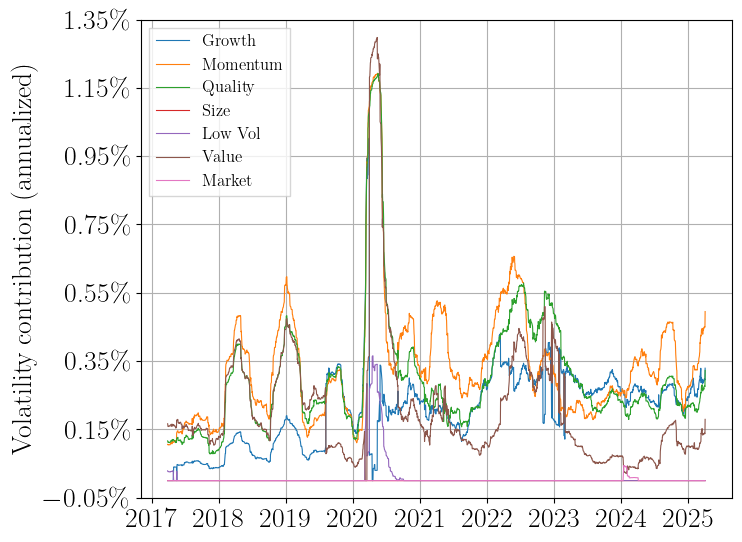

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

def plot_volatility_contributions(strategy_name,
                                  run_results,
                                  returns_df,
                                  factor_labels,
                                  window=60):          # rolling window (trading-days) for Σ
    # --- align weights & returns ----------------------------------------------
    w = run_results[strategy_name]["weights_view"]
    if "Risk-Off" not in strategy_name:
        w = w.drop(columns=["rf"], errors="ignore")
    w = w.reindex(returns_df.index).ffill().fillna(0)

    r = returns_df[w.columns].copy()

    # --- build rolling covariance cube ----------------------------------------
    # pandas stores a Panel-like MultiIndex (date, factor) x factor
    Σ = r.rolling(window).cov().dropna()

    # helper: marginal & total risk for a single date
    def _risk_decomp(t):
        s = Σ.loc[t]                         # cov-matrix at t  (DataFrame)
        w_t = w.loc[t].values               # weights vector   (np.array)
        σ_p = np.sqrt(w_t @ s.values @ w_t) # total portfolio σ
        if σ_p == 0:
            return pd.Series(0, index=s.index)

        mcr = s.values @ w_t / σ_p          # marginal contribs
        return pd.Series(w_t * mcr, index=s.index)

    # --- compute contribution series ------------------------------------------
    dates   = Σ.index.get_level_values(0).unique()
    contrib = pd.DataFrame({d: _risk_decomp(d) for d in dates}).T
    contrib = contrib.rename(columns=factor_labels)

    # use absolute values for the stacked %-share plot
    contrib_pos = contrib.abs()
    pct = contrib_pos.div(contrib_pos.sum(axis=1), axis=0)   # ← all ≥0

    total_vol = contrib_pos.sum(axis=1)  # matches the black line below

    # --- 1) %-share stacked area ----------------------------------------------
    # ax = pct.plot.area(figsize=(16,6))
    # ax.set_ylabel("Share of portfolio volatility")
    # ax.legend(loc="upper left")
    # ax.grid(True)
    # plt.show()

    # --- 2) absolute σ contributions & total σ --------------------------------
    contrib_pct = contrib * 100        # change units to %

    fig, ax = plt.subplots(figsize=(8, 6))

    # Plot each column
    for col in contrib_pct.columns:
        ax.plot(contrib_pct.index, contrib_pct[col], label=col, linewidth=0.8)

    # Y-axis settings
    ax.set_ylabel(r"Volatility contribution (annualized)", fontsize=20)
    ax.set_ybound(lower=-0.05, upper=1.35)
    ax.set_yticks(np.linspace(-0.05, 1.35, 8))
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=2))

    ax.tick_params(axis='both', labelsize=20)

    # Ticks, legend, and grid
    ax.legend(loc="upper left", fontsize=12, frameon=True, fancybox=False)
    ax.grid(True)

    fig.tight_layout()
    fig.savefig("vol_contribution.png", dpi=300) 

    plt.show()





chosen_strategy = "Dynamic Allocation (4 per cent TE)"  # or "Dynamic Allocation (1 per cent TE)" etc.
plot_volatility_contributions(chosen_strategy, run_results, test_df, factor_labels)


                                Ann.Return  Ann.Ex.Return  Ann.Ex.Vol  Sharpe
Name                                                                         
IWF (Growth factor) – Timing        0.1509         0.1259      0.2684  0.5765
IWF (Growth factor) – Buy-hold      0.1443         0.1195      0.2152  0.6327
IWF (Growth factor) – Timing-α      0.0104        -0.0116      0.1346 -0.0192


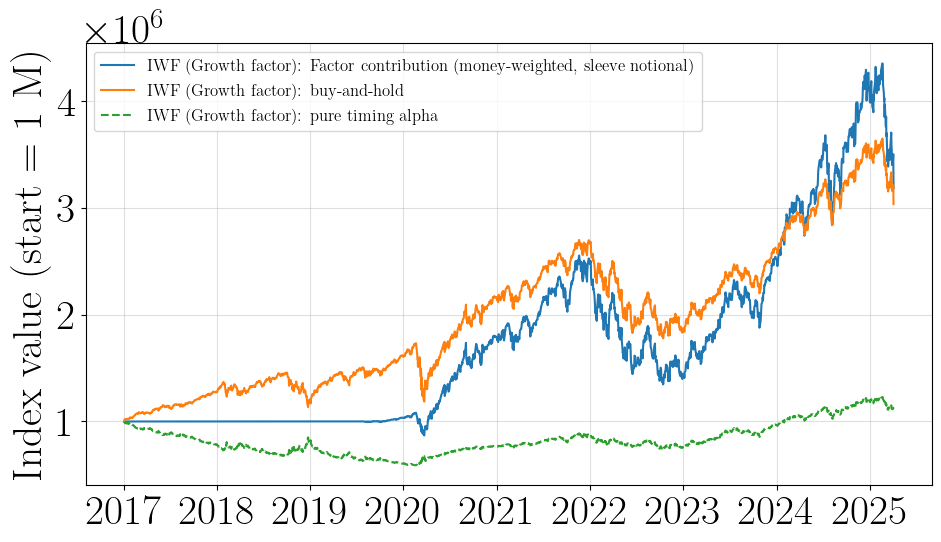

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt


# def compare_factor_timing_full_exposure(
#     strategy_name: str,
#     factor: str,
#     run_results: dict,
#     returns_df: pd.DataFrame,
#     rf_daily: pd.Series | None = None,
#     initial_notional: float = 1_000_000.0,
#     factor_labels: dict | None = None,
# ):
#     """
#     Timing vs. buy-and-hold with *full 100 % factor exposure*.

#     Scaling:
#         timing_ret[t]   = (w(t-1)/w_bar) * r_factor[t]
#         const_ret[t]    = r_factor[t]
#         alpha_ret[t]    = ((w(t-1)-w_bar)/w_bar) * r_factor[t]

#     All indices start at `initial_notional`, so charts & stats are intuitive.
#     """

#     # ---------- tiny helpers ---------------------------------------------
#     def ann_ret(r): g=(1+r).prod(); return g**(252/len(r))-1 if g>0 else np.nan
#     def ann_vol(r): return r.std()*np.sqrt(252)
#     def sharpe(r,rf=None):
#         ex=r-rf if (rf is not None and len(r)==len(rf)) else r
#         return (ex.mean()/ex.std())*np.sqrt(252) if ex.std() else np.nan
#     esc = lambda s: (s.replace("%", r"\%")
#                       .replace("&", r"\&")
#                       .replace("\u0304", ""))

#     nice = factor_labels.get(factor, factor) if factor_labels else factor

#     # ---------- pull series ----------------------------------------------
#     idx   = run_results[strategy_name]["returns"].index
#     fac_r = returns_df[factor].reindex(idx).fillna(0)
#     w     = (run_results[strategy_name]["weights_actual"]
#              .reindex(idx).ffill().fillna(0)[factor])
#     w_bar = w.mean() if w.mean() != 0 else 1e-9  # avoid div-by-zero

#     # ---------- daily returns (full exposure) ----------------------------
#     r_const = fac_r                                  # 100 % buy-and-hold
#     r_time  = (w.shift(1) / w_bar).fillna(0) * fac_r
#     r_alpha = ((w.shift(1)-w_bar) / w_bar).fillna(0) * fac_r

#     # ---------- build indices --------------------------------------------
#     def make_index(r):
#         idx_val = (1 + r).cumprod() * initial_notional
#         idx_val.iloc[0] = initial_notional
#         return idx_val

#     idx_const = make_index(r_const)
#     idx_time  = make_index(r_time)
#     idx_alpha = make_index(r_alpha)

#     # ---------- stats -----------------------------------------------------
#     if rf_daily is not None:
#         rf_daily = rf_daily.reindex(idx).fillna(0)

#     rows=[]
#     for lbl,r in [("Timing",r_time),("Buy-hold",r_const),("Timing-α",r_alpha)]:
#         rows.append({
#             "Name"          : f"{nice} – {lbl}",
#             "Ann.Return"    : ann_ret(r),
#             "Ann.Ex.Return" : ann_ret(r-rf_daily) if rf_daily is not None else np.nan,
#             "Ann.Ex.Vol"    : ann_vol(r-rf_daily) if rf_daily is not None else ann_vol(r),
#             "Sharpe"        : sharpe(r, rf_daily)
#         })
#     print(pd.DataFrame(rows).set_index("Name").round(4))

#     # ---------- plot ------------------------------------------------------
#     plt.figure(figsize=(10,6))
#     plt.plot(idx_time,  label=esc(f"{nice}: Factor contribution (money-weighted, sleeve notional)"))
#     plt.plot(idx_const, label=esc(f"{nice}: buy-and-hold"))
#     plt.plot(idx_alpha, label=esc(f"{nice}: pure timing alpha"), linestyle='--')
#     # plt.title(esc(f"{nice} timing vs buy-and-hold | {strategy_name}"))
#     plt.ylabel("Index value (start = 1 M)")
#     plt.grid(alpha=.4)
#     plt.legend(loc="upper left", fontsize=12)
#     try: plt.tight_layout()
#     except RuntimeError: pass
#     plt.show()


# # ---------------- example ----------------
# compare_factor_timing_full_exposure(
#     strategy_name   ="Dynamic Allocation (1 per cent TE)",
#     factor          ="iwf",
#     run_results     =run_results,
#     returns_df      =test_df,
#     rf_daily        =etf_df["rf"],
#     initial_notional=1_000_000.0,
#     factor_labels   =factor_labels,
# )



================  Dynamic Allocation (1 per cent TE)  ================

                                    Ann.Return  Ann.Ex.Return  Ann.Ex.Vol  Sharpe
Name                                                                             
IWF (Growth factor) – Timing            0.0133        -0.0087      0.0204 -0.4164
IWF (Growth factor) – Const-w           0.0119        -0.0101      0.0164 -0.6049
IWF (Growth factor) – Timing-alpha      0.0014        -0.0203      0.0103 -1.9920


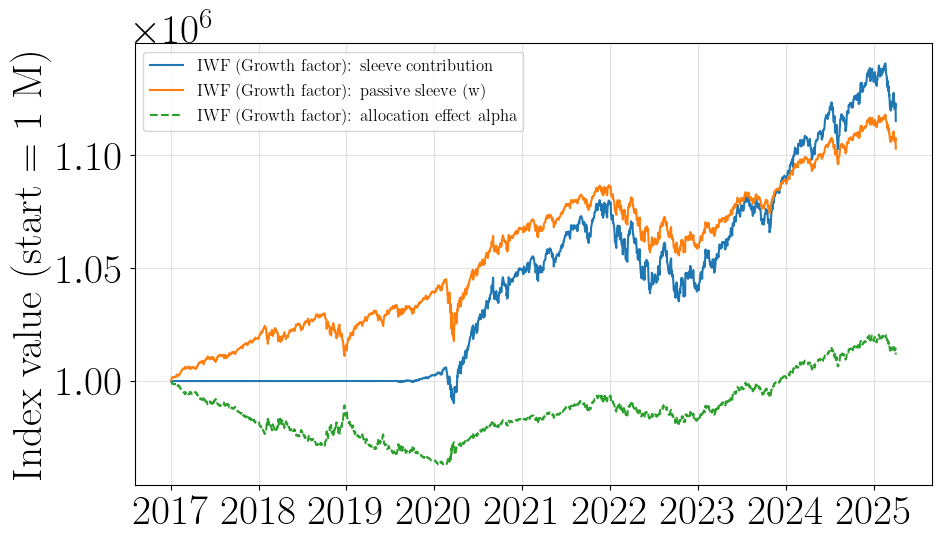

                                       Ann.Return  Ann.Ex.Return  Ann.Ex.Vol  Sharpe
Name                                                                                
MTUM (Momentum factor) – Timing            0.0382         0.0157      0.0533  0.3189
MTUM (Momentum factor) – Const-w           0.0357         0.0132      0.0503  0.2884
MTUM (Momentum factor) – Timing-alpha      0.0025        -0.0192      0.0108 -1.7861


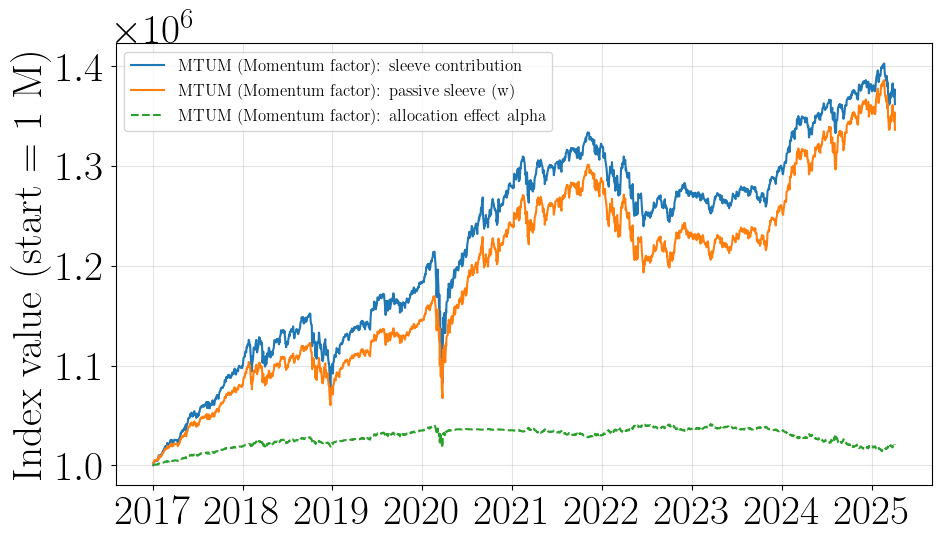

                                      Ann.Return  Ann.Ex.Return  Ann.Ex.Vol  Sharpe
Name                                                                               
QUAL (Quality factor) – Timing            0.0364         0.0139      0.0552  0.2767
QUAL (Quality factor) – Const-w           0.0379         0.0154      0.0545  0.3119
QUAL (Quality factor) – Timing-alpha     -0.0015        -0.0232      0.0060 -3.9331


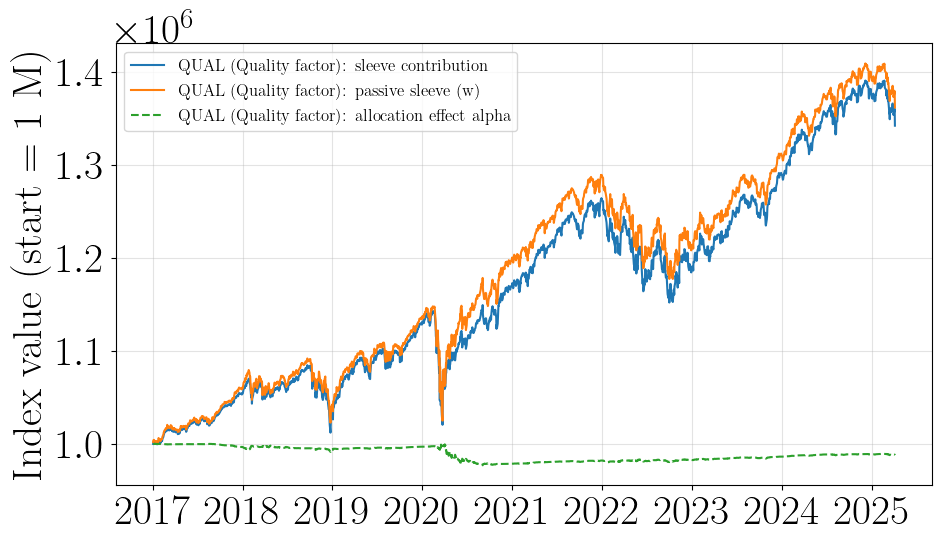

                                   Ann.Return  Ann.Ex.Return  Ann.Ex.Vol   Sharpe
Name                                                                             
SIZE (Size factor) – Timing            0.0067        -0.0152      0.0159  -0.9537
SIZE (Size factor) – Const-w           0.0064        -0.0155      0.0159  -0.9788
SIZE (Size factor) – Timing-alpha      0.0003        -0.0214      0.0017 -13.0238


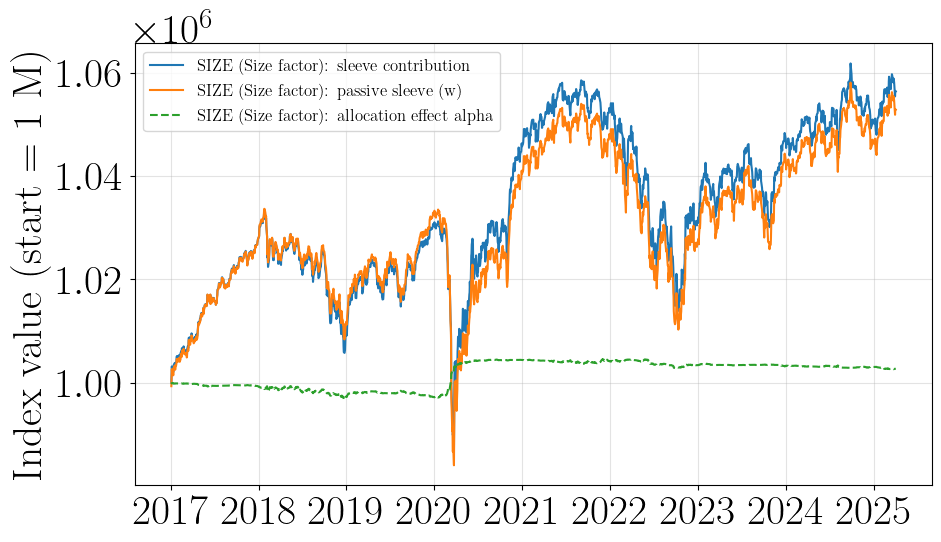

                                             Ann.Return  Ann.Ex.Return  Ann.Ex.Vol  Sharpe
Name                                                                                      
USMV (Low-volatility factor) – Timing            0.0081        -0.0138      0.0135 -1.0222
USMV (Low-volatility factor) – Const-w           0.0078        -0.0141      0.0108 -1.3060
USMV (Low-volatility factor) – Timing-alpha      0.0003        -0.0214      0.0041 -5.2769


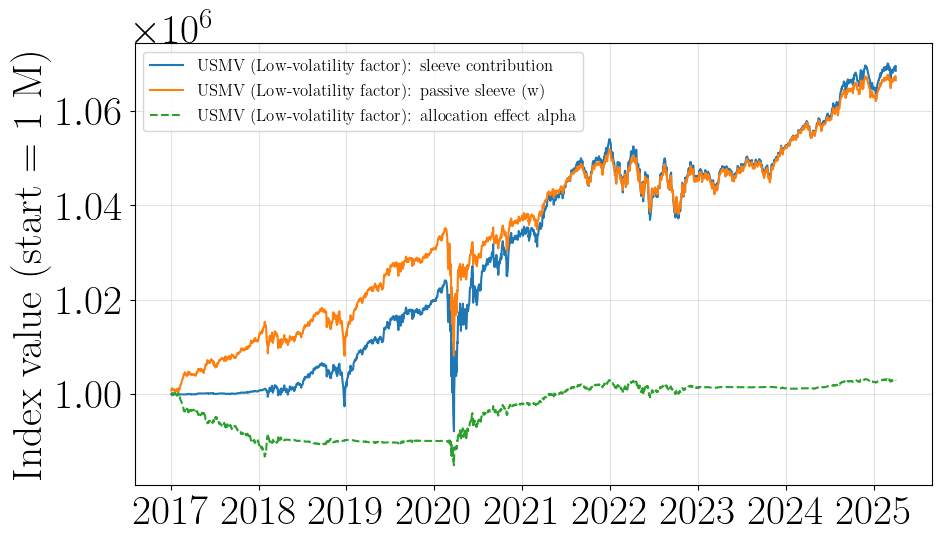

                                    Ann.Return  Ann.Ex.Return  Ann.Ex.Vol  Sharpe
Name                                                                             
VLUE (Value factor) – Timing            0.0189        -0.0032      0.0399 -0.0615
VLUE (Value factor) – Const-w           0.0170        -0.0051      0.0425 -0.0920
VLUE (Value factor) – Timing-alpha      0.0017        -0.0200      0.0066 -3.0481


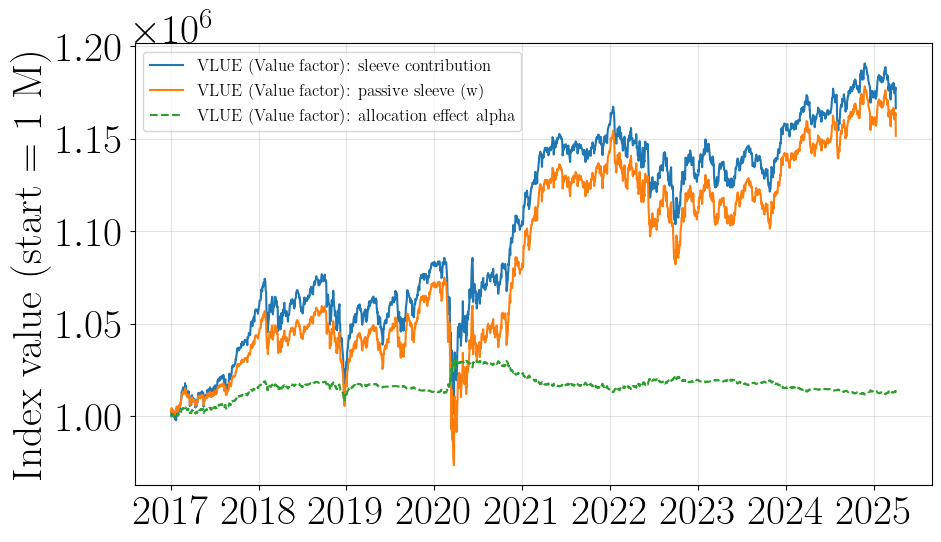

                       Ann.Return  Ann.Ex.Return  Ann.Ex.Vol   Sharpe
Name                                                                 
Market – Timing              -0.0        -0.0217      0.0012 -18.8816
Market – Const-w             -0.0        -0.0217      0.0012 -18.8819
Market – Timing-alpha         0.0        -0.0217      0.0012 -18.8814


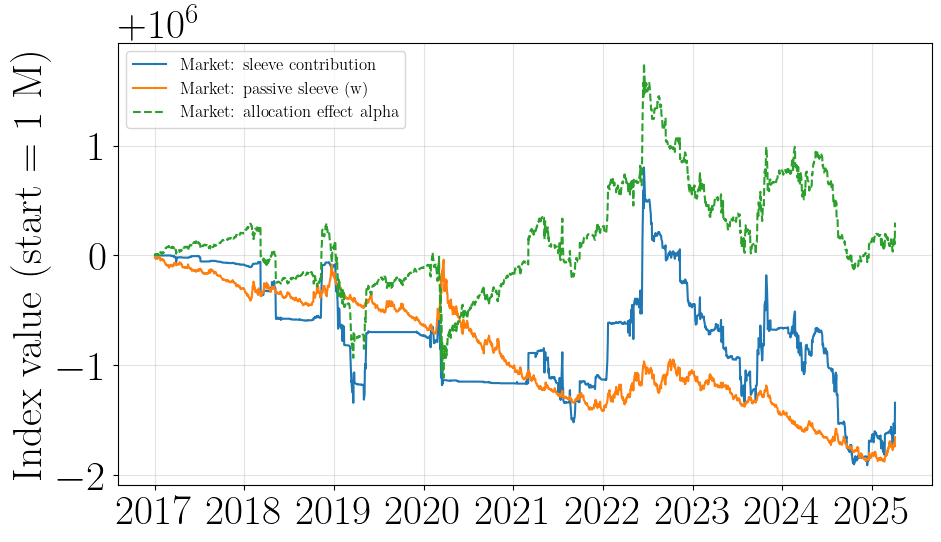

In [ ]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt


# def compare_factor_timing_brinson(
#     strategy_name: str,
#     factor: str,
#     run_results: dict,
#     returns_df: pd.DataFrame,
#     rf_daily: pd.Series | None = None,
#     initial_notional: float = 1_000_000.0,
#     factor_labels: dict | None = None,
# ):
#     """
#     Classic Brinson allocation-effect view:

#         timing_ret[t] = w(t-1)            * r_factor[t]     (sleeve P&L)
#         const_ret[t]  = w̄                * r_factor[t]     (passive sleeve)
#         alpha_ret[t]  = (w(t-1)-w̄)       * r_factor[t]     (allocation effect)

#     All indices start at `initial_notional`.
#     """

#     # helpers
#     # ── REPLACE THE TWO HELPER FUNCTIONS ───────────────────────────────────────
#     def ann_ret(r: pd.Series) -> float:
#         """geometric mean: (Π (1+r))^(252/n) − 1   — skip the first dummy row"""
#         r = r.iloc[1:]                 # drop the naïve zero on day-0
#         if r.empty: 
#             return np.nan
#         total = (1 + r).prod()
#         return total**(252/len(r)) - 1


#     def ann_vol(r: pd.Series) -> float:
#         """annualised st.dev  – also skip first dummy row"""
#         r = r.iloc[1:]
#         return r.std() * np.sqrt(252)
# # ───────────────────────────────────────────────────────────────────────────

#     def sharpe(r,rf=None):
#         ex=r-rf if (rf is not None and len(r)==len(rf)) else r
#         return (ex.mean()/ex.std())*np.sqrt(252) if ex.std() else np.nan
#     esc = lambda s: (s.replace("%", r"\%").replace("&", r"\&").replace("\u0304",""))

#     nice = factor_labels.get(factor, factor) if factor_labels else factor

#     # series
#     idx   = run_results[strategy_name]["returns"].index
#     fac_r = returns_df[factor].reindex(idx).fillna(0)
#     w     = run_results[strategy_name]["weights_actual"][factor].reindex(idx).ffill().fillna(0)
#     w_bar = w.mean()

#     # daily returns (money-weighted, no scaling)
#     r_const = w_bar * fac_r
#     r_time  = w.shift(1).fillna(0) * fac_r
#     r_alpha = (w.shift(1)-w_bar).fillna(0) * fac_r

#     # build indices
#     make_idx = lambda r: (1+r).cumprod().mul(initial_notional).rename(None)
#     idx_const, idx_time, idx_alpha = map(make_idx, [r_const, r_time, r_alpha])

#     # stats
#     if rf_daily is not None:
#         rf_daily = rf_daily.reindex(idx).fillna(0)
#     rows=[]
#     for lbl,r in [("Timing",r_time),("Const-w",r_const),("Timing-alpha",r_alpha)]:
#         rows.append({
#             "Name": f"{nice} – {lbl}",
#             "Ann.Return"   : ann_ret(r),
#             "Ann.Ex.Return": ann_ret(r-rf_daily) if rf_daily is not None else np.nan,
#             "Ann.Ex.Vol"   : ann_vol(r-rf_daily) if rf_daily is not None else ann_vol(r),
#             "Sharpe"       : sharpe(r, rf_daily)
#         })
#     print(pd.DataFrame(rows).set_index("Name").round(4))

#     # plot
#     plt.figure(figsize=(10,6))
#     plt.plot(idx_time,  label=esc(f"{nice}: sleeve contribution"))
#     plt.plot(idx_const, label=esc(f"{nice}: passive sleeve (w̄)"))
#     plt.plot(idx_alpha, label=esc(f"{nice}: allocation effect alpha"), linestyle='--')
#     plt.ylabel("Index value (start = 1 M)")
#     plt.grid(alpha=.35)
#     plt.legend(loc="upper left", fontsize=12)
#     try: plt.tight_layout()
#     except RuntimeError: pass
#     plt.show()

# # ------------------------------------------------------------------
# # 1) make sure the function is in scope  (from previous cell / file)
# #     compare_factor_timing_brinson(...)
# # ------------------------------------------------------------------


# # -------- user knobs ---------------------------------------------
# strategies_to_check = [
#     "Dynamic Allocation (1 per cent TE)",
#     # "Dynamic Allocation (2 per cent TE)",
# ]                       # ← put any of the keys from run_results here

# factors_to_check = [f for f in test_df.columns if f != "rf"]   # all factors
# initial_notional = 1_000_000.0
# # -----------------------------------------------------------------


# for strat in strategies_to_check:
#     print(f"\n================  {strat}  ================\n")
#     for fac in factors_to_check:
#         compare_factor_timing_brinson(
#             strategy_name   = strat,
#             factor          = fac,
#             run_results     = run_results,
#             returns_df      = test_df,
#             rf_daily        = etf_df["rf"],
#             initial_notional= initial_notional,
#             factor_labels   = factor_labels,
#         )



Per-factor static-allocation contribution (percentage-points):


Factor_Alloc (pp)
vlue                -1.06
Market              -0.16
usmv                 0.32
iwf                  0.59
qual                 2.21
mtum                 3.93
size                 6.96
Total               12.79

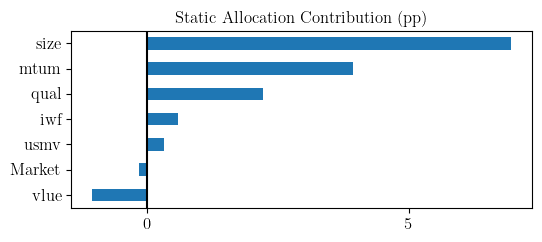

In [ ]:
# Brinson attribution – factor-timing portfolio vs benchmark
#   • Allocation (static tilts)
#   • Interaction  (timing)
#   • Geometric linking via Carino so pieces add exactly
# ════════════════════════════════════════════════════════════════
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# -------- parameters (change as needed) -------------------------
strategy_label  = "Dynamic Allocation (4 per cent TE)"
benchmark_label = "Benchmark (Q-Rebalanced EW)"
# ----------------------------------------------------------------


def brinson_daily_allocation(w_port, w_bench, factor_ret):
    common = [c for c in w_port.columns if c in w_bench.columns
              and c in factor_ret.columns and c.lower() != "rf"]
    wp, wb, rf = w_port[common], w_bench[common], factor_ret[common]
    bench_ret  = (wb * rf).sum(axis=1)            # total benchmark return
    excess     = rf.sub(bench_ret, axis=0)        # sleeve excess return
    return (wp - wb).mul(excess, axis=0)          # Fachler allocation



def carino_link(series_active, series_total):
    """Carino (1999) geometric linker for any daily active series."""
    scale = (1 + series_total).cumprod().shift().fillna(1)
    return (series_active * scale).sum()

# --- annualise ----------------------------------------------------
days  = len(rel_daily)
years = days / 252.0

def annualise(g):
    return (1 + g)**(1/years) - 1          # geometric CAGR

alloc_ann = annualise(alloc_geo)
inter_ann = annualise(inter_geo)
total_ann = annualise(total_geo)           # should match perf table

# --- summary table ------------------------------------------------
totals = pd.DataFrame({
    "Geometric Total": [alloc_geo, inter_geo, total_geo],
    "Annualised":     [alloc_ann, inter_ann, total_ann]
}, index=["Allocation", "Interaction", "Total Alpha"])

display(totals.style.format("{:+.2%}"))


# --- pull inputs -------------------------------------------------
w_port   = run_results[strategy_label]  \
             .get("weights_actual", run_results[strategy_label]["weights_view"])
w_bench  = run_results[benchmark_label] \
             .get("weights_actual", run_results[benchmark_label]["weights_view"])

factor_ret = test_df.drop(columns="rf", errors="ignore")

ret_port  = run_results[strategy_label]["returns"]
ret_bench = run_results[benchmark_label]["returns"]
rel_daily = ret_port.sub(ret_bench, fill_value=0)

# --- allocation & interaction (daily) ----------------------------
alloc_daily = brinson_daily_allocation(w_port, w_bench, factor_ret).sum(axis=1)
inter_daily = rel_daily - alloc_daily                  # timing piece

# --- Carino geometric totals -------------------------------------
alloc_geo = carino_link(alloc_daily, rel_daily)
inter_geo = carino_link(inter_daily, rel_daily)
total_geo = (1 + rel_daily).prod() - 1                 # check figure

# --- per-factor arithmetic contributions (for colour) ------------
factor_totals = brinson_daily_allocation(
    w_port, w_bench, factor_ret).sum().sort_values()

# --- tidy printout ----------------------------------------------
summary = pd.DataFrame({
    "Factor_Alloc (pp)": (factor_totals*100).round(2)
})
summary.loc["Total", "Factor_Alloc (pp)"] = summary["Factor_Alloc (pp)"].sum()
print("Per-factor static-allocation contribution (percentage-points):")
display(summary)

# --- summary table ------------------------------------------------
totals = pd.DataFrame({
    "Geometric Total": [alloc_geo, inter_geo, total_geo],
    "Annualised":     [alloc_ann, inter_ann, total_ann]
}, index=["Allocation", "Interaction", "Total Alpha"])

display(totals.style.format("{:+.2%}"))

# --- quick bar-chart (static allocation) -------------------------
summary.drop("Total").plot.barh(
    legend=False, figsize=(6,3), title="Static Allocation Contribution (pp)", fontsize=12)
plt.title("Static Allocation Contribution (pp)", fontsize=12)
plt.axvline(0, color="black")
plt.tight_layout()
plt.show()


Annualised (%)
Static Allocation         1.989959
Dynamic Allocation       -0.581349
Security Selection        0.614363
Total Alpha               2.040967

Per-factor allocation contribution (percentage-points):


Static  Dynamic  Total_pp
vlue     -4.23     0.20     -4.03
usmv      0.21    -2.15     -1.94
Market   -0.68     0.43     -0.25
qual      2.59    -0.18      2.41
iwf       4.01    -1.47      2.54
mtum      4.92    -1.02      3.90
size     10.82    -0.50     10.32

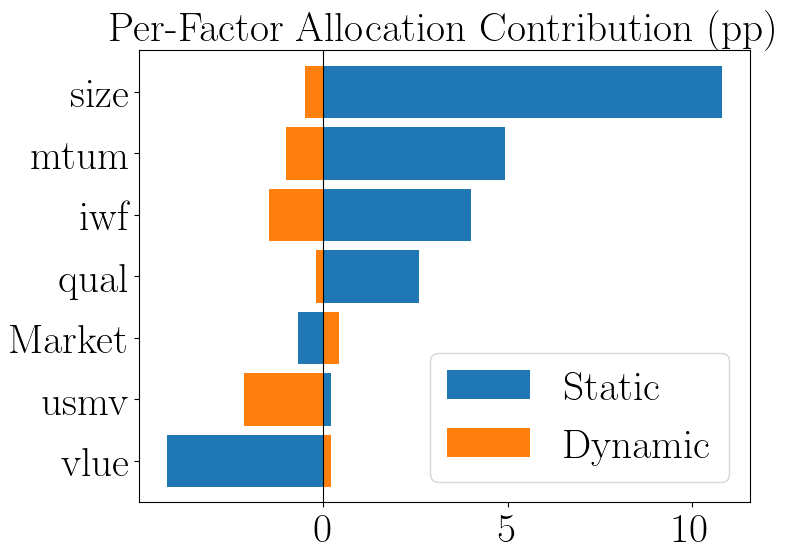

In [ ]:
# # Hsu-Kalesnik-Myers dynamic-allocation attribution
# # Implements Eqs. 8a–8d exactly as in Hsu-Kalesnik-Myers (2010)
# # ───────────────────────────────────────────────────────────────
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # ───────── user parameters ─────────────────────────────────────
# strategy_label  = "Dynamic Long-Short Allocation (4 per cent TE)"
# benchmark_label = "Benchmark (Q-Rebalanced EW)"
# # ───────────────────────────────────────────────────────────────

# # ===== 1. LOAD DATA ========================================================
# w_port  = run_results[strategy_label]  \
#             .get("weights_actual", run_results[strategy_label]["weights_view"])
# w_bench = run_results[benchmark_label] \
#             .get("weights_actual", run_results[benchmark_label]["weights_view"])

# # columns must be factor sleeves (ETF tickers, indices, etc.)
# factor_ret = test_df.drop(columns="rf", errors="ignore")      # R i,t b
# ret_port   = run_results[strategy_label]["returns"]           # total P&L

# # keep only the sleeves present in *all* three frames
# common = w_port.columns.intersection(w_bench.columns).intersection(factor_ret.columns)
# w_port, w_bench, factor_ret = w_port[common], w_bench[common], factor_ret[common]

# # ===== 2. BUILD BENCHMARK RETURN  R b,t  =========================
# bench_ret = (w_bench * factor_ret).sum(axis=1)                # Eq. 3
# rel_daily = ret_port - bench_ret                               # portfolio α_t

# # ===== 3. FACTOR-LEVEL ALLOCATION (Brinson–Fachler) =============
# excess    = factor_ret.sub(bench_ret, axis=0)                  # R i,t b − R t b
# wp_minus_wb = w_port - w_bench
# alloc_pf  = wp_minus_wb * excess                               # per-factor alloc
# alloc_daily = alloc_pf.sum(axis=1)                             # Σ_i …  → Eq. 8a

# # ===== 4. SPLIT ALLOCATION INTO STATIC & DYNAMIC ===============
# tilt_bar  = wp_minus_wb.mean()                                 #  w̄_i  (persistent)
# static_pf_daily = excess.mul(tilt_bar, axis=1)                 # Eq. 8b day-path
# static_daily    = static_pf_daily.sum(axis=1)

# dynamic_daily   = alloc_daily - static_daily                   # Eq. 8c (timing)

# # ===== 5. SECURITY-SELECTION  (Eq. 8d) ==========================
# #  Σ_i w_i,t^p (R_i,t^p − R_i,t^b)  =  α_t − allocation_t
# selection_daily = rel_daily - alloc_daily

# # ===== 6. CARINO GEOMETRIC LINKER ===============================
# def carino(series_active, total_active):
#     cum = (1 + total_active).cumprod().shift().fillna(1)
#     return (series_active * cum).sum()

# static_geo    = carino(static_daily,    rel_daily)
# dynamic_geo   = carino(dynamic_daily,   rel_daily)
# selection_geo = carino(selection_daily, rel_daily)
# total_geo     = (1 + rel_daily).prod() - 1                      # check value

# assert np.isclose(static_geo + dynamic_geo + selection_geo,
#                   total_geo, atol=1e-10), "Pieces do not reconcile!"

# # ===== 7. ANNUALISE & DISPLAY ==================================
# years = len(rel_daily) / 252.0
# to_cagr = lambda g: (1 + g)**(1/years) - 1

# summary = pd.Series({
#     "Static Allocation":   to_cagr(static_geo)   * 100,
#     "Dynamic Allocation":  to_cagr(dynamic_geo)  * 100,
#     "Security Selection":  to_cagr(selection_geo)* 100,
#     "Total Alpha":         to_cagr(total_geo)    * 100
# }).rename("Annualised (%)")

# display(summary.to_frame())

# # ===== 8. OPTIONAL PER-FACTOR BAR PLOT =========================
# static_fac_geo  = static_pf_daily.apply(lambda s: carino(s, rel_daily))
# dynamic_fac_geo = (alloc_pf - static_pf_daily).apply(lambda s: carino(s, rel_daily))

# factor_contrib = pd.concat([static_fac_geo, dynamic_fac_geo], axis=1,
#                            keys=["Static", "Dynamic"]).mul(100).round(2)
# factor_contrib["Total_pp"] = factor_contrib.sum(axis=1)
# factor_contrib = factor_contrib.sort_values("Total_pp")

# print("Per-factor allocation contribution (percentage-points):")
# display(factor_contrib)

# factor_contrib[["Static", "Dynamic"]].plot.barh(
#     stacked=True, figsize=(8,6), width=0.85,
#     title="Per-Factor Allocation Contribution (pp)")
# plt.axvline(0, color="black", lw=.8)
# plt.tight_layout()
# plt.show()


Per-factor allocation contribution (percentage-points):


Static Allocation  Dynamic Allocation  Total_pp
VLUE (Value factor)                       -1.95                0.86     -1.09
USMV (Low-volatility factor)              -0.12               -0.22     -0.34
Market                                     0.06                0.11      0.17
IWF (Growth factor)                        1.16               -0.82      0.34
QUAL (Quality factor)                      2.18               -0.20      1.98
MTUM (Momentum factor)                     4.38               -1.04      3.34
SIZE (Size factor)                         5.83               -0.14      5.69

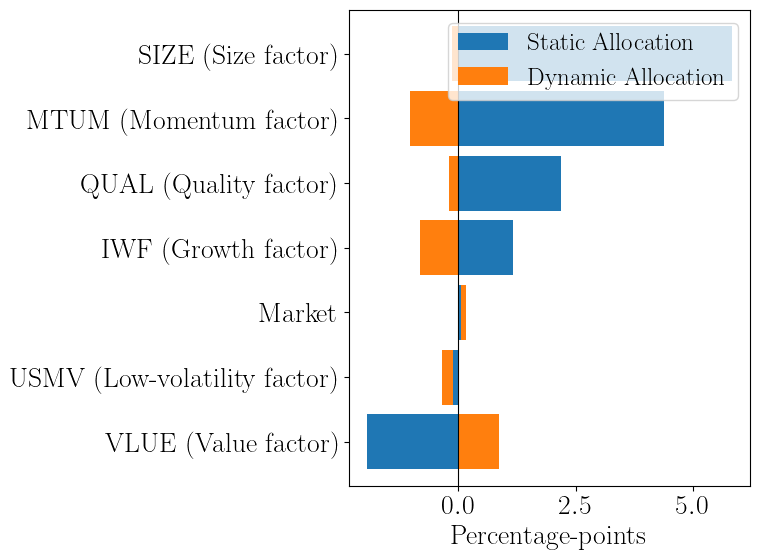

Annualised (%)
Static Allocation         1.465209
Dynamic Allocation       -0.196601
Security Selection        1.006153
Total Alpha               2.208767

Static Allocation     1.465209
Dynamic Allocation   -0.196601
Security Selection    1.006153
Total Alpha           2.208767
Name: Annualised (%), dtype: float64


In [ ]:
# # Brinson attribution with Hsu–Kalesnik–Myers split ## will give right outperformance
# #   • Static allocation  (persistent tilts)
# #   • Dynamic allocation (true timing, covariance term)
# #   • Security selection
# #   • Carino geometric linking (pieces add exactly)
# # ════════════════════════════════════════════════════════════════
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# # -------- parameters (change as needed) -------------------------
# strategy_label  = "Dynamic Allocation (4 per cent TE)"  # Dynamic Allocation with Risk-Off, Dynamic Long-Short Allocation with Risk-Off
# benchmark_label = "Benchmark (Q-Rebalanced EW)"
# # ----------------------------------------------------------------

# # ------------ helpers -------------------------------------------
# def brinson_daily_allocation(w_port, w_bench, factor_ret):
#     """Fachler (1985) daily allocation effect per factor."""
#     common = [c for c in w_port.columns
#               if c in w_bench.columns and c in factor_ret.columns
#               and c.lower() != "rf"]
#     wp, wb, fr = w_port[common], w_bench[common], factor_ret[common]
#     bench_ret = (wb * fr).sum(axis=1)
#     excess    = (1 + fr).div(1 + bench_ret, axis=0) - 1   # ← change here
#     return (wp - wb).mul(excess, axis=0), excess    # per-factor alloc, excess rtns


# def carino_link(active_series, total_active):
#     """Carino (1999) geometric linker."""
#     scale = (1 + total_active).cumprod().shift().fillna(1)
#     return (active_series * scale).sum()


# def annualise(geom_return, n_days):
#     """Convert geometric return to CAGR."""
#     years = n_days / 252.0
#     return (1 + geom_return)**(1 / years) - 1
# # ----------------------------------------------------------------

# # ---------- pull inputs -----------------------------------------
# w_port   = run_results[strategy_label]  \
#              .get("weights_actual", run_results[strategy_label]["weights_view"])
# w_bench  = run_results[benchmark_label] \
#              .get("weights_actual", run_results[benchmark_label]["weights_view"])

# factor_ret = test_df.drop(columns="rf", errors="ignore")

# ret_port  = run_results[strategy_label]["returns"]
# ret_bench = run_results[benchmark_label]["returns"]
# rel_daily = (1 + ret_port)/(1 + ret_bench) - 1            # active rtn series

# # ---------- allocation pieces -----------------------------------
# alloc_pf, excess = brinson_daily_allocation(w_port, w_bench, factor_ret)
# alloc_daily = alloc_pf.sum(axis=1)                           # classical Brinson

# # ----- Hsu–Kalesnik–Myers split ---------------------------------
# wp_diff = w_port[alloc_pf.columns] - w_bench[alloc_pf.columns]
# wp_bar  = wp_diff.mean()                                     # persistent tilt

# # static: persistent tilt × current excess rtns
# static_daily_df = excess.mul(wp_bar, axis=1)
# static_daily    = static_daily_df.sum(axis=1)

# # dynamic: residual allocation effect
# dynamic_daily = alloc_daily - static_daily

# if "factor_labels" in globals():          # skip if dict not defined
#     alloc_pf          = alloc_pf.rename(columns=factor_labels)
#     static_daily_df   = static_daily_df.rename(columns=factor_labels)
#     excess            = excess.rename(columns=factor_labels)

# # ---------- security selection (unchanged) ----------------------
# selection_daily = rel_daily - alloc_daily

# # ----------------------------------------------------------------
# # Factor-level static & dynamic contributions (percentage-points)
# # ----------------------------------------------------------------
# static_fac_daily   = static_daily_df                          # already per factor
# dynamic_fac_daily  = alloc_pf - static_fac_daily              # residual = dynamic

# static_fac_geo  = static_fac_daily .apply(lambda s: carino_link(s, rel_daily))
# dynamic_fac_geo = dynamic_fac_daily.apply(lambda s: carino_link(s, rel_daily))

# factor_contrib = pd.concat(
#     [static_fac_geo, dynamic_fac_geo], axis=1,
#     keys=["Static Allocation", "Dynamic Allocation"]
# ).mul(100).round(2)                                # convert to p.p.
# factor_contrib["Total_pp"] = factor_contrib.sum(axis=1)
# factor_contrib = factor_contrib.sort_values("Total_pp")

# print("Per-factor allocation contribution (percentage-points):")
# display(factor_contrib)

# # ---- bar-chart "Per-Factor Allocation Contribution (pp)"---------
# plt.rcParams.update({'font.size': 20})

# ax = factor_contrib[["Static Allocation", "Dynamic Allocation"]].plot.barh(
#     stacked=True, figsize=(8, 6), width=0.85)

# ax.set_xlabel("Percentage-points", fontsize=20)          # inherits 20 pt
# ax.axvline(0, color="black", linewidth=0.8)

# # keep ticks and title at 20 pt
# ax.tick_params(axis='both', labelsize=20)
# ax.set_title(ax.get_title(), fontsize=20)

# # legend only 12 pt
# ax.legend(fontsize=18)

# plt.tight_layout()
# plt.show()

# # ---------- Carino geometric totals -----------------------------
# static_geo    = carino_link(static_daily,    rel_daily)
# dynamic_geo   = carino_link(dynamic_daily,   rel_daily)
# selection_geo = carino_link(selection_daily, rel_daily)
# total_geo     = (1 + rel_daily).prod() - 1

# # ---------- convert to the table’s additive units ---------------
# bench_cagr = ann_return(ret_bench)   # helper you defined earlier
# scale      = 1 + bench_cagr               # e.g. 1.103 if benchmark = 10.3 %

# static_geo    *= scale
# dynamic_geo   *= scale
# selection_geo *= scale
# total_geo     *= scale                    # now matches table gap

# # reconciliation check
# assert np.isclose(static_geo + dynamic_geo + selection_geo,
#                   total_geo, atol=1e-10)

# # ---------- annualised figures ----------------------------------
# days = len(rel_daily)
# results = pd.Series({
#     "Static Allocation":    annualise(static_geo,    days) * 100,
#     "Dynamic Allocation":   annualise(dynamic_geo,   days) * 100,
#     "Security Selection":   annualise(selection_geo, days) * 100,
#     "Total Alpha":          annualise(total_geo,     days) * 100
# }).rename("Annualised (%)")

# display(results.to_frame())
# print(results)

Strategy analysed : Risk-off 2% TE  ➜  Dynamic Allocation with Risk-Off (2 per cent TE)
Benchmark         : Benchmark (Q-Rebalanced EW)

Allocation added value  (eq 8a) :  0.533995%
Static allocation value (eq 8b) :  0.640889%
Dynamic allocation      (=8a−8b): -0.106894%

        Allocation 8a  Static 8b   Dynamic
Market      -0.000193  -0.000322  0.000129
iwf         -0.002683  -0.003036  0.000353
mtum         0.001354   0.002975 -0.001621
qual         0.002345   0.001826  0.000519
rf                NaN        NaN       NaN
size         0.006478   0.006224  0.000254
usmv         0.000336   0.000473 -0.000138
vlue        -0.002297  -0.001731 -0.000566


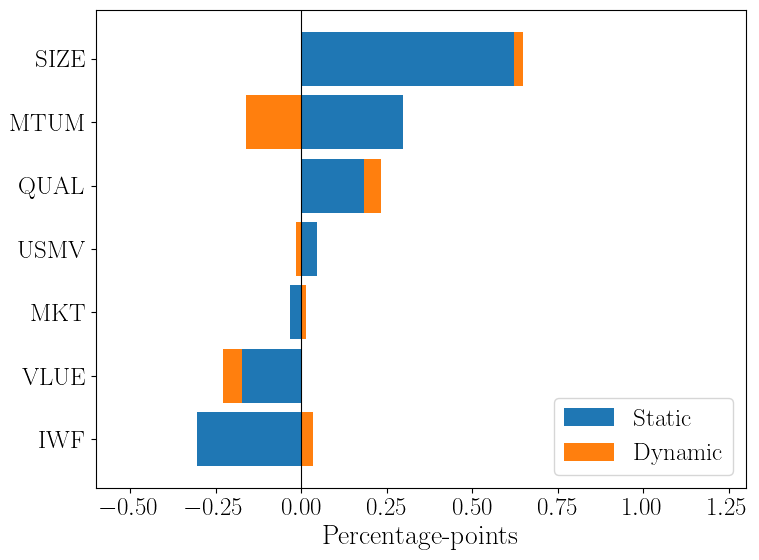

In [16]:
# ================================================================
#  Hsu–Kalesnik–Myers (2010) arithmetic attribution
#  ---------------------------------------------------------------
#  • Works on ANY strategy held in `run_results`
#  • Pick the strategy you want with the `strategy_choice` toggle
#  • Computes
#        – Allocation added value       (eq. 8a)
#        – Static  allocation added value (eq. 8b)
#        – Dynamic allocation            (= 8a − 8b)
# ================================================================

# ----------------------------------------------------------------
# 2️⃣  USER TOGGLE: pick any key from the `strategy_labels` dict
# ----------------------------------------------------------------
strategy_choice  = "Risk-off 2% TE"           # <—— change at will
benchmark_choice = "Benchmark (Q-Rebalanced EW)"

strategy_label   = strategy_labels.get(strategy_choice,  strategy_choice)
benchmark_label  = strategy_labels.get(benchmark_choice, benchmark_choice)

# ----------------------------------------------------------------
# 3️⃣  Pull weights & returns
# ----------------------------------------------------------------
w_port  = run_results[strategy_label]  \
            .get("weights_actual", run_results[strategy_label]["weights_view"])
w_bench = run_results[benchmark_label] \
            .get("weights_actual", run_results[benchmark_label]["weights_view"])

ret_port  = run_results[strategy_label]["returns"]
ret_bench = run_results[benchmark_label]["returns"]

# —— factor/ETF return matrix *aligned with the weight columns* —
# only keep overlapping factors, excluding 'rf'
common_cols = (
    w_port.columns
          .intersection(w_bench.columns)
          .difference(["rf"])
)
factor_ret = test_df[common_cols]



# ----------------------------------------------------------------
# 4️⃣  HKM arithmetic allocation helpers
# ----------------------------------------------------------------
def hkm_allocation_effects(wp: pd.DataFrame,
                           wb: pd.DataFrame,
                           fr: pd.DataFrame):
    """
    Returns eq 8a (allocation) and eq 8b (static) from
    Hsu–Kalesnik–Myers (2010). Uses arithmetic means.
    """
    # --- benchmark total return each period  Rᵇ_t
    Rb_t = (wb * fr).sum(axis=1)                      # Series (T,)

    # --- eq 8a  Allocation added value
    alloc_term  = (wp - wb).mul(fr.sub(Rb_t, axis=0), axis=0)
    alloc_added = alloc_term.sum(axis=1).mean()

    # --- eq 8b  Static allocation added value
    avg_wdiff   = (wp - wb).mean()
    avg_excess  = fr.sub(Rb_t, axis=0).mean()
    static_added = (avg_wdiff * avg_excess).sum()

    return alloc_added, static_added

# ----------------------------------------------------------------
# 🔎 HKM arithmetic allocation – with factor-by-factor breakdown
# ----------------------------------------------------------------
def hkm_allocation_effects_breakdown(wp: pd.DataFrame,
                                     wb: pd.DataFrame,
                                     fr: pd.DataFrame):
    """
    • alloc_total   : eq 8a (scalar)
    • static_total  : eq 8b (scalar)
    • alloc_series  : eq 8a, factor-by-factor  (pd.Series, len = N)
    • static_series : eq 8b, factor-by-factor  (pd.Series, len = N)
    """
    # benchmark return each period  Rᵇ_t
    Rb_t = (wb * fr).sum(axis=1)

    # ----- eq 8a  allocation added value
    alloc_term     = (wp - wb).mul(fr.sub(Rb_t, axis=0), axis=0)   # T×N
    alloc_series   = alloc_term.mean()        # 1/T Σ_t (…)   – one number per factor
    alloc_total    = alloc_series.sum()       # sum_i

    # ----- eq 8b  static allocation added value
    avg_wdiff      = (wp - wb).mean()         # 1/T Σ_t (wᵖ−wᵇ)
    avg_excess     = fr.sub(Rb_t, axis=0).mean()   # 1/T Σ_t (Rᵇ_i−Rᵇ_t)
    static_series  = avg_wdiff * avg_excess   # term-by-term product
    static_total   = static_series.sum()

    return alloc_total, static_total, alloc_series, static_series


# ----------------------------------------------------------------
# 5️⃣  Run the attribution for the chosen strategy
# ----------------------------------------------------------------
alloc_val, static_val = hkm_allocation_effects(w_port, w_bench, factor_ret)
dynamic_val           = alloc_val - static_val

print(f"Strategy analysed : {strategy_choice}  ➜  {strategy_label}")
print(f"Benchmark         : {benchmark_choice}")
print()
print(f"Allocation added value  (eq 8a) : {alloc_val*252 : .6%}")
print(f"Static allocation value (eq 8b) : {static_val*252: .6%}")
print(f"Dynamic allocation      (=8a−8b): {dynamic_val*252: .6%}")

# ----------------------------------------------------------------
# 5️⃣  Run it
# ----------------------------------------------------------------
alloc_tot, static_tot, alloc_ser, static_ser = (
    hkm_allocation_effects_breakdown(w_port, w_bench, factor_ret)
)
dynamic_ser = alloc_ser - static_ser            # factor-level dynamic
dynamic_tot = alloc_tot - static_tot            # already had this

# OPTIONAL: annualise (if inputs are daily)
annualise = 252
alloc_ser_yr   = alloc_ser   * annualise
static_ser_yr  = static_ser  * annualise
dynamic_ser_yr = dynamic_ser * annualise

breakdown = pd.DataFrame({
    "Allocation 8a": alloc_ser_yr,
    "Static 8b":    static_ser_yr,
    "Dynamic":      dynamic_ser_yr
})

print()
print(breakdown)

plt.rcParams.update({'font.size': 20})

# ---------------------------------------------------------------
# Factor label mapping
# ---------------------------------------------------------------
factor_labels_attrib = {
    "iwf":  "IWF",
    "mtum": "MTUM",
    "qual": "QUAL",
    "size": "SIZE",
    "usmv": "USMV",
    "vlue": "VLUE",
    "Market": "MKT",
    # "rf":     "Risk‑free"
}

# ---------------------------------------------------------------
# Build DataFrame with factor contributions (annual %‑points)
# ---------------------------------------------------------------
df_attrib = pd.DataFrame({
    "Static": static_ser_yr * 100,
    "Dynamic":     dynamic_ser_yr * 100,
})

# Apply nicer factor names (leave unmapped items untouched)
df_attrib.index = df_attrib.index.map(lambda x: factor_labels_attrib.get(x, x))

df_attrib = df_attrib.drop(index="rf", errors=True)

# Sort as desired (e.g. by Dynamic)
df_attrib = df_attrib.sort_values("Static", ascending=True)

# ---------------------------------------------------------------
# Horizontal bar plot
# ---------------------------------------------------------------
# set base font size
static  = df_attrib["Static"].values
dynamic = df_attrib["Dynamic"].values

# for each row:
#  • if static and dynamic have the same sign, start at static
#  • otherwise start at zero
left_dyn = np.where(np.sign(static)==np.sign(dynamic), static, 0)

fig, ax = plt.subplots(figsize=(8, 6))
plt.rcParams.update({'font.size': 20})
bar_w = 0.85
y     = np.arange(len(df_attrib))

ax.barh(y, static,  bar_w, label="Static")
ax.barh(y, dynamic, bar_w, left=left_dyn, label="Dynamic")

ax.set_yticks(y)
ax.set_yticklabels(df_attrib.index, fontsize=18)
ax.set_xlabel("Percentage-points", fontsize=20)
ax.axvline(0, color="black", linewidth=0.8)
ax.tick_params(labelsize=18)
ax.legend(fontsize=18, loc="lower right")
ax.margins(x=0.05)
ax.set_xbound(-0.6, 1.3)
plt.tight_layout()
plt.show()

# plt.rcParams.update({'font.size': 20})

# ax = factor_contrib[["Static Allocation", "Dynamic Allocation"]].plot.barh(
#     stacked=True, figsize=(8, 6), width=0.85)

# ax.set_xlabel("Percentage-points", fontsize=20)          # inherits 20 pt
# ax.axvline(0, color="black", linewidth=0.8)

# # keep ticks and title at 20 pt
# ax.tick_params(axis='both', labelsize=20)
# ax.set_title(ax.get_title(), fontsize=20)

# # legend only 12 pt
# ax.legend(fontsize=18)

# plt.tight_layout()
# plt.show()

In [11]:
# Yearly buy-hold factor performances
def calculate_yearly_factor_metrics(returns_df, start_date='2017-01-01', risk_free_col='rf'):
    import pandas as pd, numpy as np

    returns = returns_df.copy().loc[start_date:]
    rf = returns[risk_free_col]
    excess = returns.drop(columns=[risk_free_col]).sub(rf, axis=0)
    excess['year'] = excess.index.year
    grp = excess.groupby('year')
    
    # yearly metrics
    er = pd.DataFrame({y: g.drop(columns='year').mean() * 252 for y, g in grp}).T
    ev = pd.DataFrame({y: g.drop(columns='year').std() * np.sqrt(252) for y, g in grp}).T
    sr = er.div(ev)
    
    # total-period metrics
    all_ret = excess.drop(columns='year')
    total_er = all_ret.mean() * 252
    total_ev = all_ret.std() * np.sqrt(252)
    total_sr = total_er / total_ev
    
    # append Total row
    for df, total in [(er, total_er), (ev, total_ev), (sr, total_sr)]:
        df.loc['Total'] = total
    
    return {
        'excess_return': er,
        'excess_vol':     ev,
        'sharpe_ratio':   sr
    }

# then rename columns & display as before
yearly_metrics = calculate_yearly_factor_metrics(etf_df)
for m in yearly_metrics:
    yearly_metrics[m] = yearly_metrics[m].rename(columns=factor_labels)

print("Yearly Factor Excess Returns:")
display(yearly_metrics['excess_return'].style.format("{:.4f}"))

print("\nYearly Factor Excess Volatility:")
display(yearly_metrics['excess_vol'].style.format("{:.4f}"))

print("\nYearly Factor Sharpe Ratios:")
display(yearly_metrics['sharpe_ratio'].style.format("{:.4f}"))


Yearly Factor Excess Returns:



Yearly Factor Excess Volatility:



Yearly Factor Sharpe Ratios:


In [ ]:
#Statistical test for difference in Sharpe ratios

def _moments(x):
    μ      = x.mean()
    σ      = x.std(ddof=0)              # population std. dev.
    m3     = ((x-μ)**3).mean()          # third central moment
    m4     = ((x-μ)**4).mean()          # fourth central moment
    γ3, γ4 = m3/σ**3 , m4/σ**4          # skew- & kurtosis‐coefficients
    return μ, σ, γ3, γ4

def _var_sr(μ, σ, γ3, γ4, SR, T):
    return ( (γ4-1)/4  - SR*γ3 + 0.5*SR**2 ) / T

def _cross_moments(a, b):
    """
    Unbiased h-statistics for μ22, μ12, μ21  (Opdyke 2006 App. C)
    """
    n   = len(a)
    da  = a - a.mean()
    db  = b - b.mean()

    s1a = da.sum();          s1b = db.sum()
    s2a = (da**2).sum();     s2b = (db**2).sum()
    s11 = (da*db).sum()

    μ22 = (n*s2a*s2b - (n+1)*s2a*s2b + 2*s11**2) / (n*(n-1)*(n-2)*(n-3))
    μ12 = (n*(da*db**2).sum() - 2*s1a*s2b - s1b*s11) / (n*(n-1)*(n-2))
    μ21 = (n*(db*da**2).sum() - 2*s1b*s2a - s1a*s11) / (n*(n-1)*(n-2))
    return μ22, μ12, μ21

def opdyke_z(a, b, rf=0.0, periods=252):
    # excess returns  – drop NaNs first
    ra, rb = np.asarray(a) - rf, np.asarray(b) - rf
    mask   = ~np.isnan(ra) & ~np.isnan(rb)
    ra, rb = ra[mask], rb[mask]
    T      = len(ra)

    # moments & SRs
    μa, σa, γ3a, γ4a = _moments(ra)
    μb, σb, γ3b, γ4b = _moments(rb)
    SRa, SRb        = μa/σa, μb/σb

    # variances
    Va = _var_sr(μa, σa, γ3a, γ4a, SRa, T)
    Vb = _var_sr(μb, σb, γ3b, γ4b, SRb, T)

    # covariance part
    μ22, μ12, μ21   = _cross_moments(ra, rb)
    rho             = np.corrcoef(ra, rb)[0,1]
    # --- just replace your Cab assignment ---
    Cab = ((μ22/(4*σa**2*σb**2)
            - SRa*μ12/(2*σa*σb**2)
            - SRb*μ21/(2*σa**2*σb)
            + 0.5*rho*SRa*SRb)      
            / T)                      

    # test statistic
    denom = Va + Vb - 2*Cab          # Var(SRa−SRb)
    if denom <= 0:                   # finite-sample collapse – test is undefined
        return SRa*np.sqrt(periods), SRb*np.sqrt(periods), np.nan, np.nan
    z  = (SRa - SRb) / np.sqrt(denom)
    p  = 2*(1 - stats.norm.cdf(abs(z)))
    return SRa*np.sqrt(periods), SRb*np.sqrt(periods), z, p

bench = ew_rets
for name, res in run_results.items():
    sr_a, sr_b, z, p = opdyke_z(res["returns"], bench)
    print(f"{name:30s} ΔSR={sr_a-sr_b:+.3f}, z={z:+.2f}, p={p:.3f}")


Dynamic Allocation (4 per cent TE) ΔSR=+0.077, z=+0.08, p=0.938
Dynamic Allocation (3 per cent TE) ΔSR=+0.071, z=+0.07, p=0.944
Dynamic Allocation (2 per cent TE) ΔSR=+0.066, z=+0.06, p=0.949
Dynamic Allocation (1 per cent TE) ΔSR=+0.075, z=+0.07, p=0.943
Dynamic Long-Short Allocation (4 per cent TE) ΔSR=+0.063, z=+0.06, p=0.951
Dynamic Long-Short Allocation (3 per cent TE) ΔSR=+0.073, z=+0.07, p=0.944
Dynamic Long-Short Allocation (2 per cent TE) ΔSR=+0.085, z=+0.08, p=0.935
Dynamic Long-Short Allocation (1 per cent TE) ΔSR=+0.093, z=+0.09, p=0.929
Dynamic Allocation with Risk-Off (4 per cent TE) ΔSR=+0.325, z=+0.37, p=0.708
Dynamic Allocation with Risk-Off (3 per cent TE) ΔSR=+0.340, z=+0.39, p=0.696
Dynamic Allocation with Risk-Off (2 per cent TE) ΔSR=+0.360, z=+0.41, p=0.681
Dynamic Allocation with Risk-Off (1 per cent TE) ΔSR=+0.405, z=+0.46, p=0.645
Benchmark (Q-Rebalanced EW)    ΔSR=+0.000, z=+0.00, p=1.000
Benchmark (Market Buy-Hold)    ΔSR=+0.003, z=+0.00, p=0.998


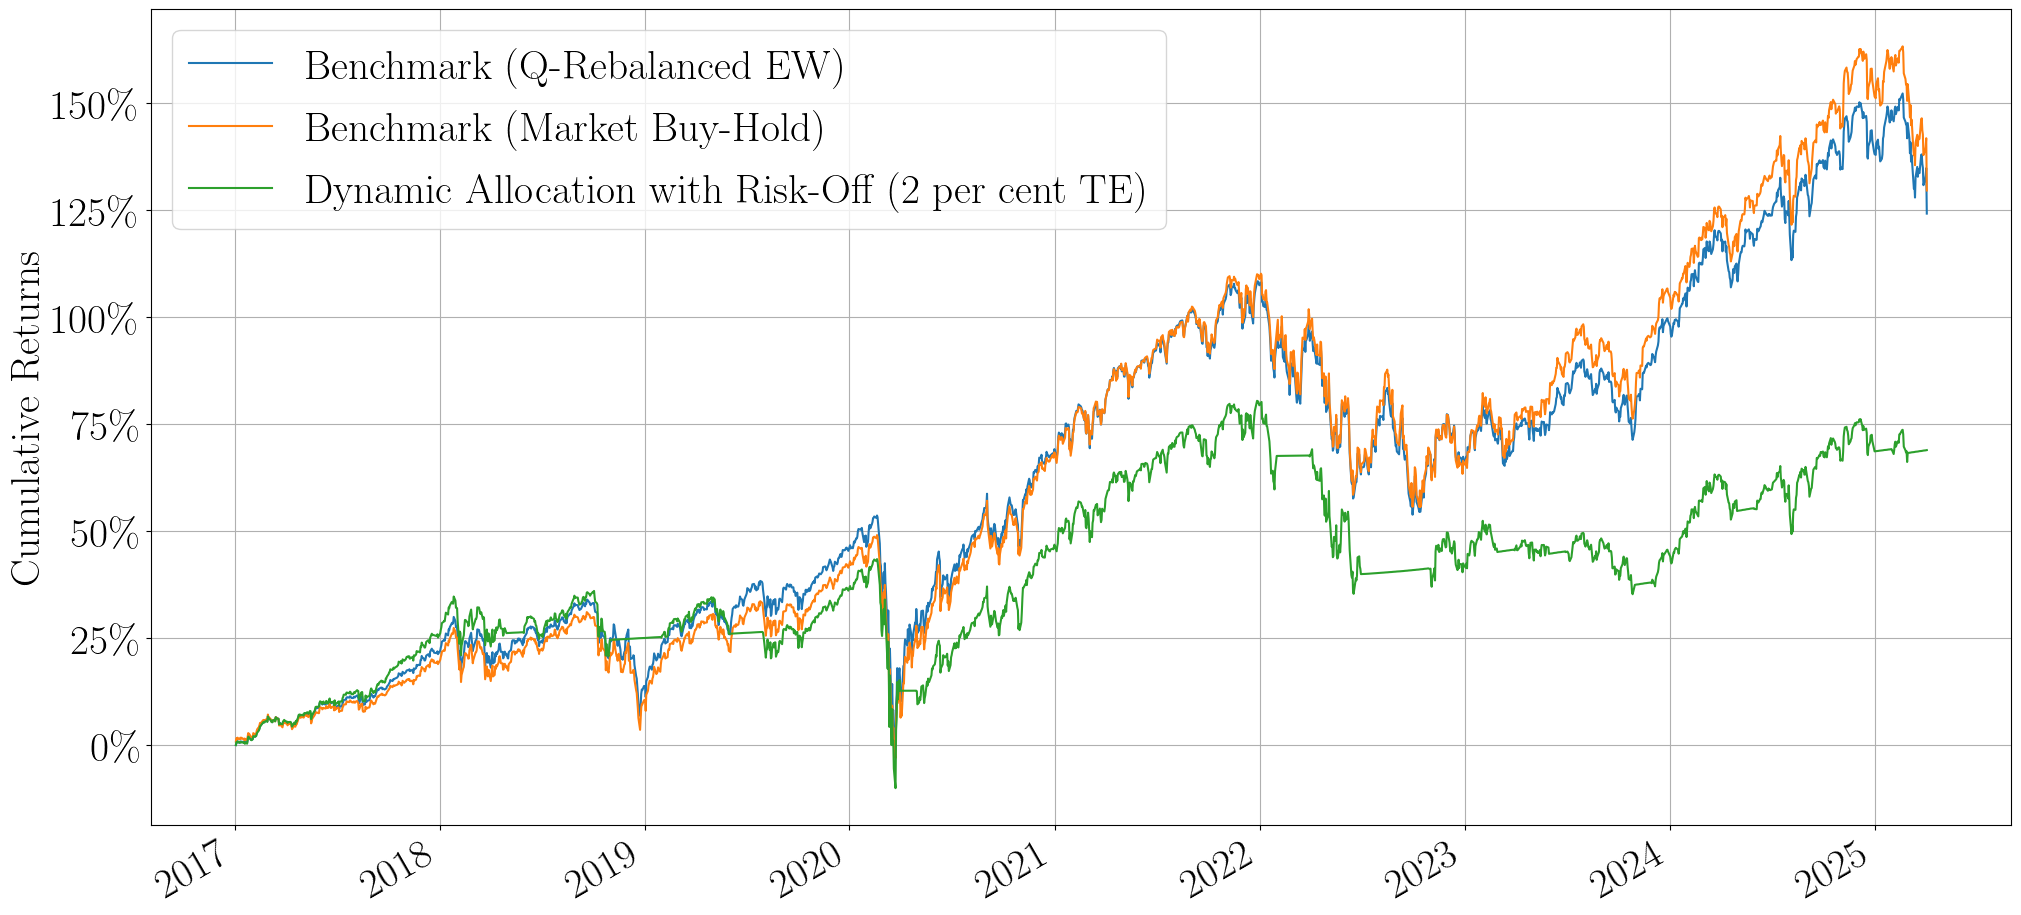

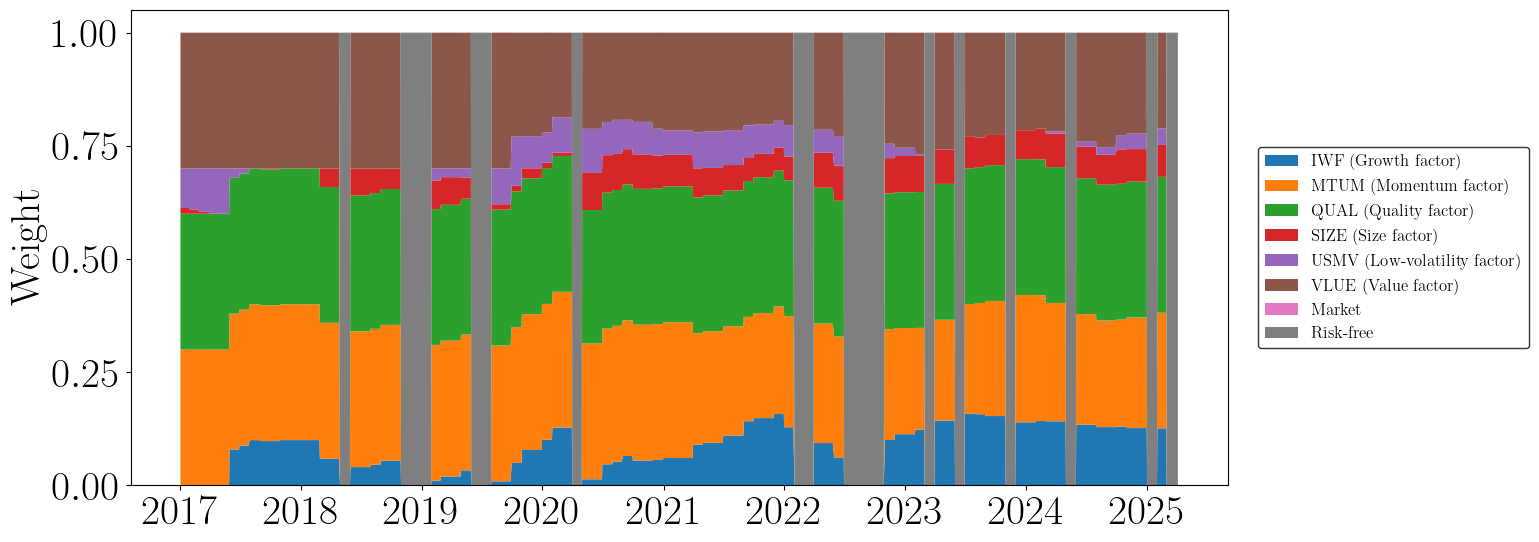

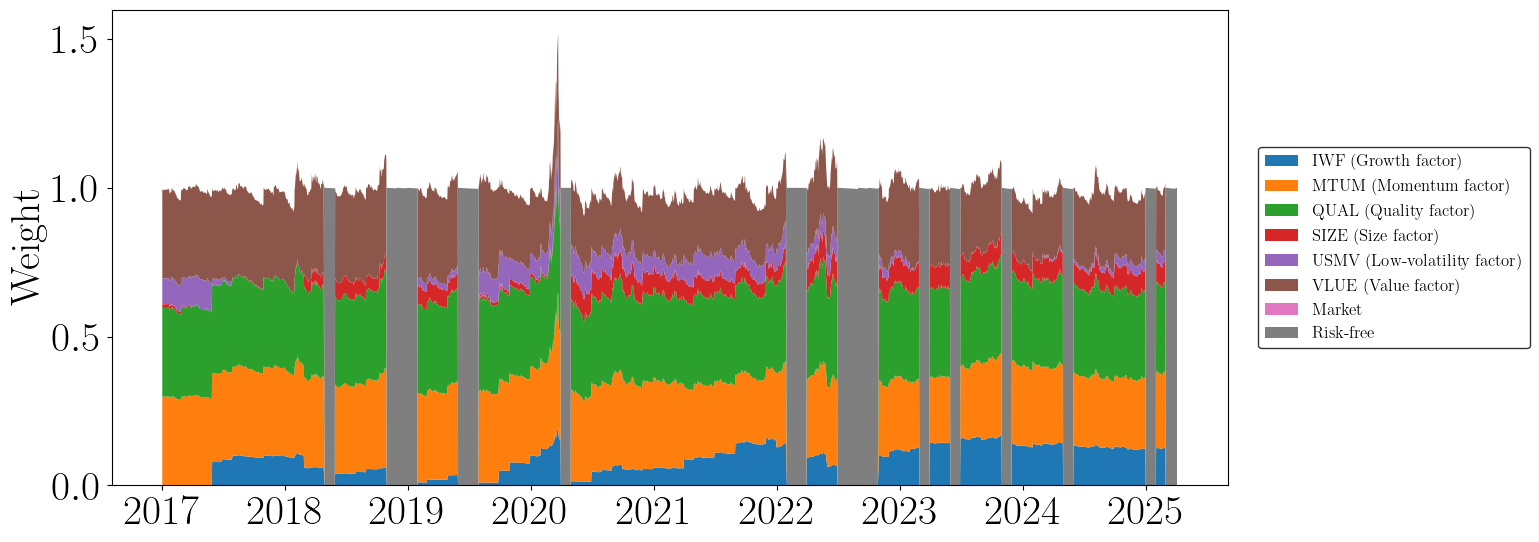

In [21]:
# Plots for save
_update(
    compare=list(cmp.value),      # the configs you ticked in “Compare”
    weights_cfg=wgt.value,        # the config chosen in “Weights”
    sign_filter=sign.value        # 'both' / 'pos' / 'neg' from the toggle
)

                                               CAPM beta
Strategy                                                
Dynamic Allocation (4 per cent TE)                 1.016
Dynamic Long-Short Allocation (4 per cent TE)      1.041
Dynamic Allocation (1 per cent TE)                 0.924
Dynamic Long-Short Allocation (1 per cent TE)      0.916


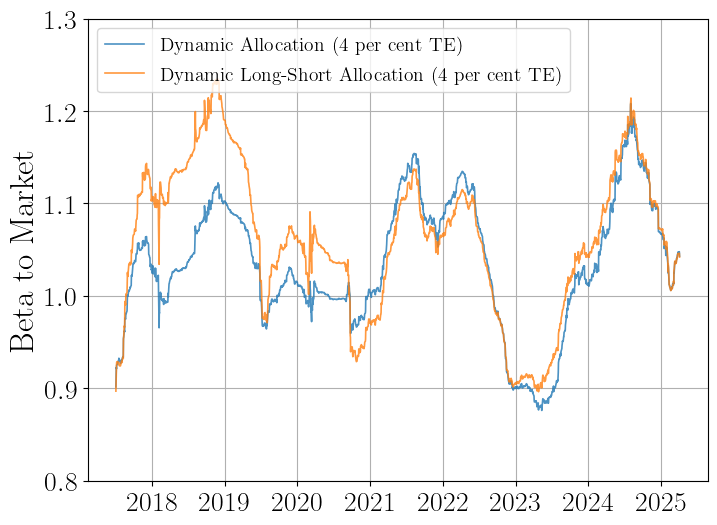

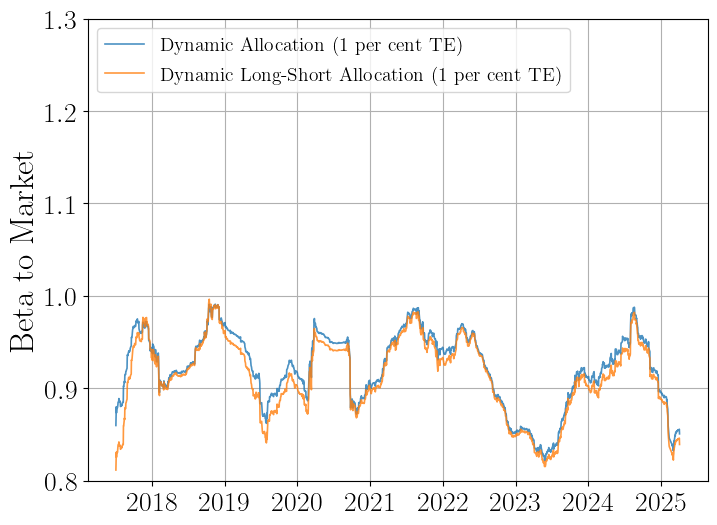

In [192]:
# ------------------------------------------------------------
# QUICK CHECK — Is the L/S book really beta-neutral?
# ------------------------------------------------------------
#
# 1)  Pick the strategies you want to test.
#     (Long-only vs. corresponding long-short at the same TE.)
# 2)  Regress each portfolio’s *excess* daily returns on the
#     market’s *excess* daily returns → CAPM beta.
# 3)  Print both the full-sample beta and a 6-month rolling beta
#     so you can see whether neutrality is stable through time.
#
# Assumes `run_results` (your strategies) and `etf_df["Market"]`
# are already in memory, exactly as in your notebook.
# ------------------------------------------------------------

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

def capm_beta(port_ret, mkt_ret):
    """OLS beta of portfolio excess return vs. market excess return."""
    y, x = port_ret.align(mkt_ret, join="inner")
    x = sm.add_constant(x)           # adds 'const' plus an unnamed column
    model = sm.OLS(y, x, missing="drop").fit()
    # beta is the coefficient after the intercept, whatever it's called
    return model.params.drop("const").iloc[0]



# -------- pick strategies ---------------------------------------
pairs = [
    ("Dynamic Allocation (4 per cent TE)",  "Dynamic Long-Short Allocation (4 per cent TE)"),
    ("Dynamic Allocation (1 per cent TE)",  "Dynamic Long-Short Allocation (1 per cent TE)"),
    # ("Base model 1% TE",  "L/S 1% TE"),
]

mkt = etf_df["Market"].loc[full_idx] - etf_df["rf"].loc[full_idx]   # excess market return

results = []

for long_only, long_short in pairs:
    for lab in (long_only, long_short):
        r  = run_results[lab]["returns"]       # daily total return
        rex = r - etf_df["rf"].reindex(r.index)  # excess return
        beta = capm_beta(rex, mkt)
        results.append({"Strategy": lab, "CAPM beta": beta})

df_beta = pd.DataFrame(results).set_index("Strategy")
print(df_beta.round(3))

# -------- optional: rolling beta plot ---------------------------
window = 126     # ~6 months of trading days

for long_only, long_short in pairs:
    fig, ax = plt.subplots(figsize=(8, 6))

    for lab, color in [(long_only, "tab:blue"), (long_short, "tab:orange")]:
        r = run_results[lab]["returns"]
        rex = r - etf_df["rf"].reindex(r.index)
        roll_beta = (
            rex.rolling(window)
               .cov(mkt)
               / mkt.rolling(window).var()
        )
        ax.plot(roll_beta.index, roll_beta.values, label=lab, color=color, alpha=0.8, lw=1.2)

    ax.axhline(0, color="grey", ls="--", linewidth=1.5)
    ax.set_ylabel("Beta to Market", fontsize=24)
    ax.set_xlabel("", fontsize=20)
    ax.set_ylim(0.8, 1.3)
    
    ax.legend(loc="upper left", fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='both', labelsize=20)

    plt.show()



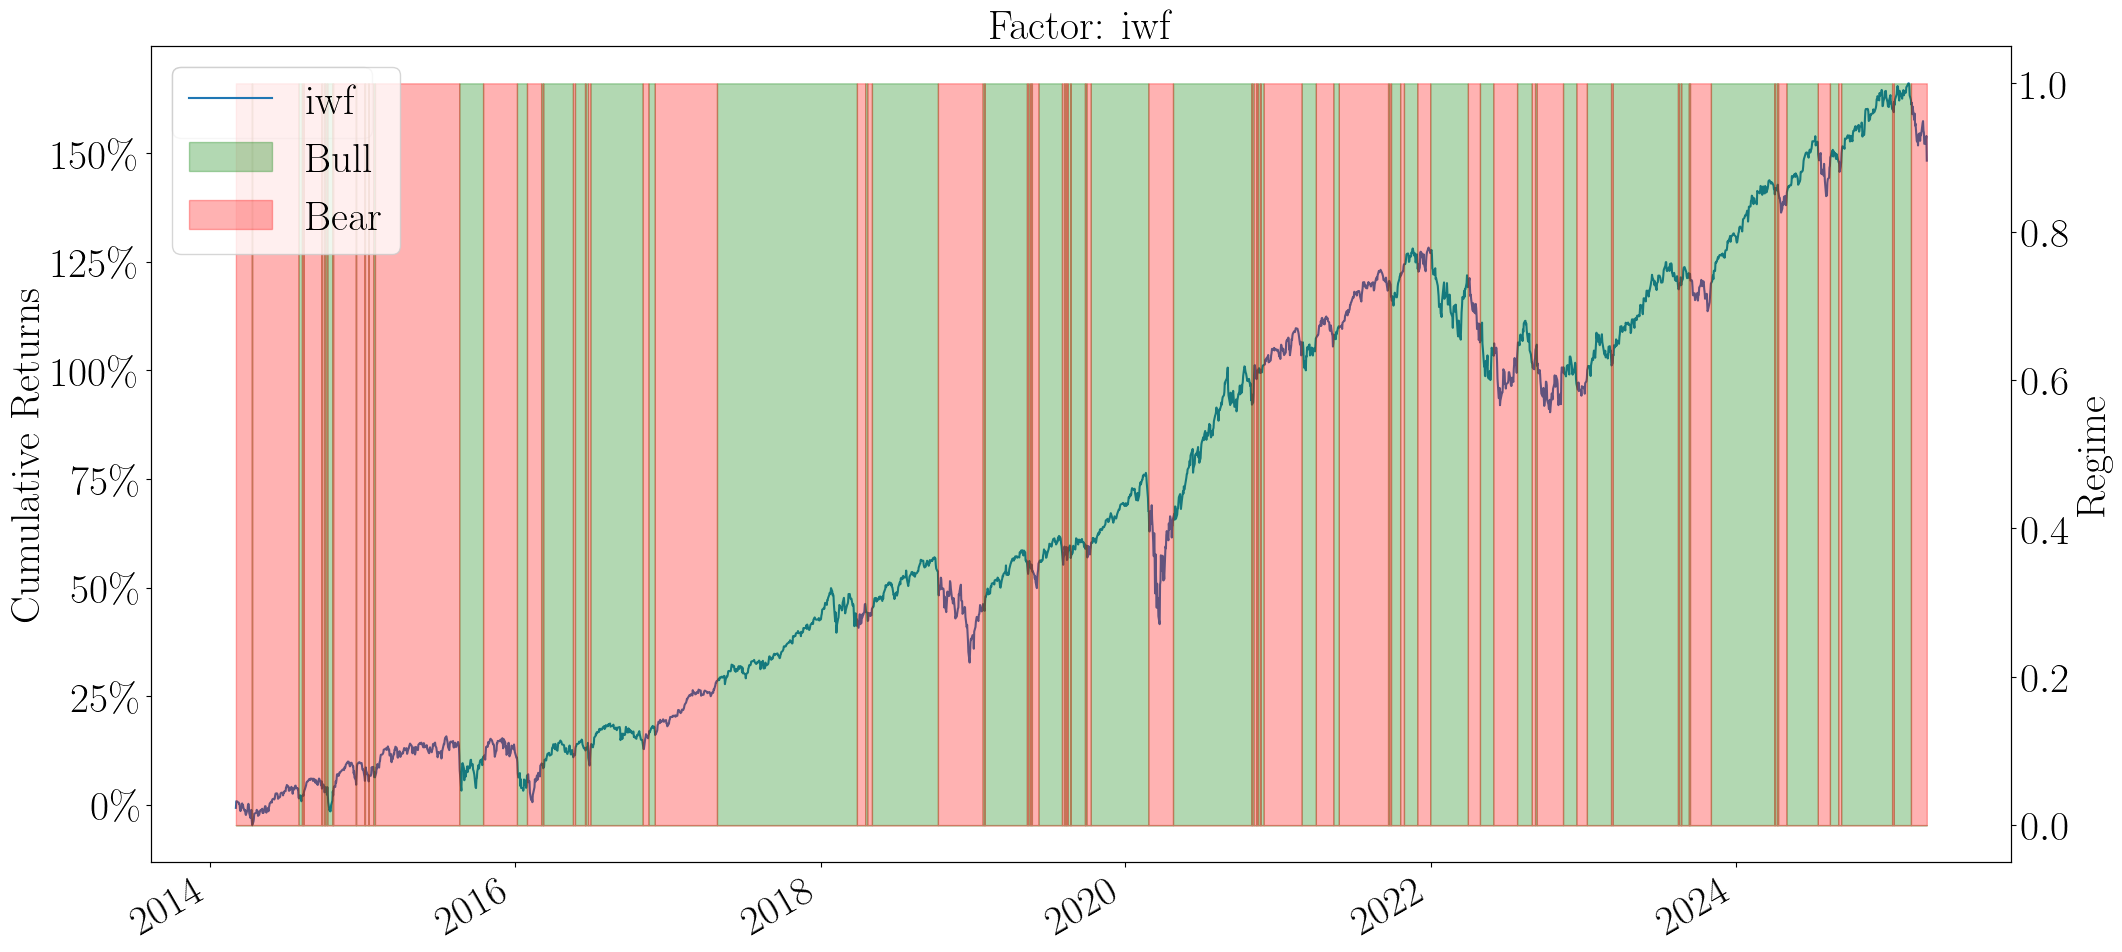

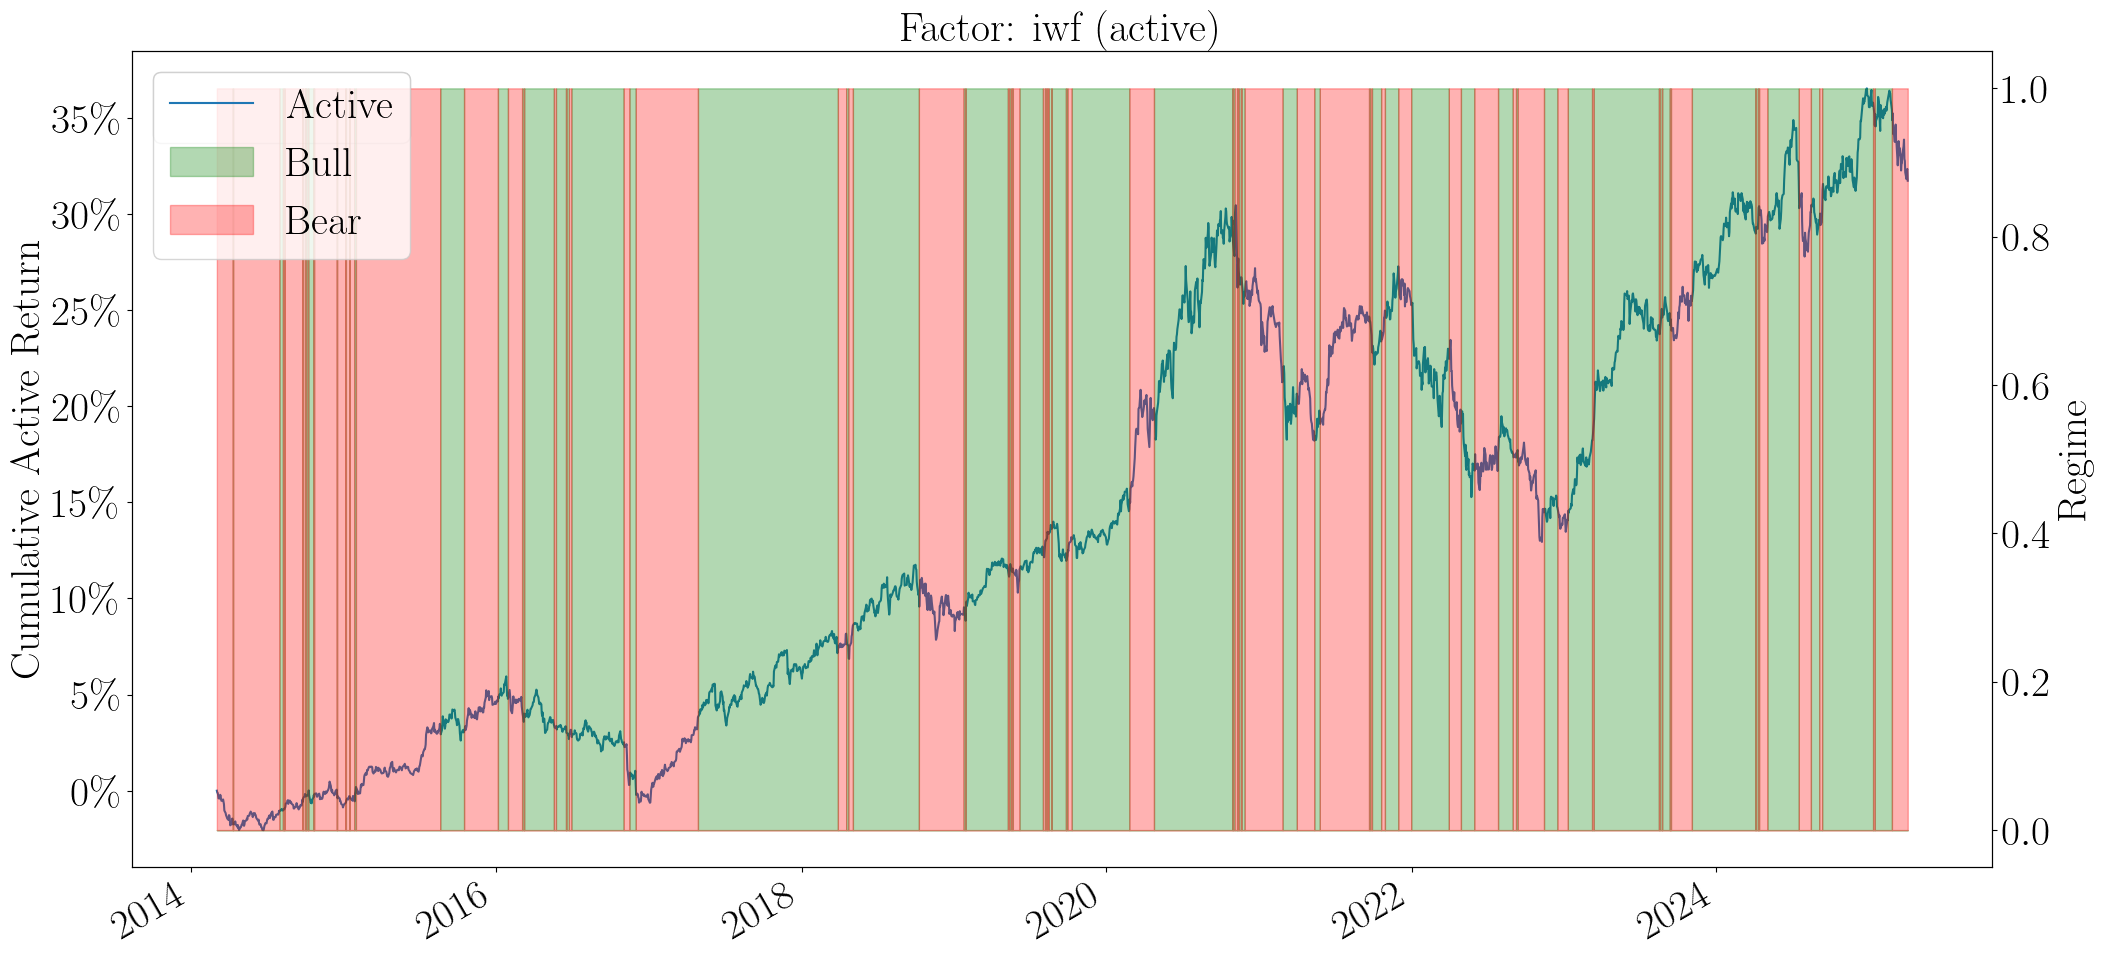

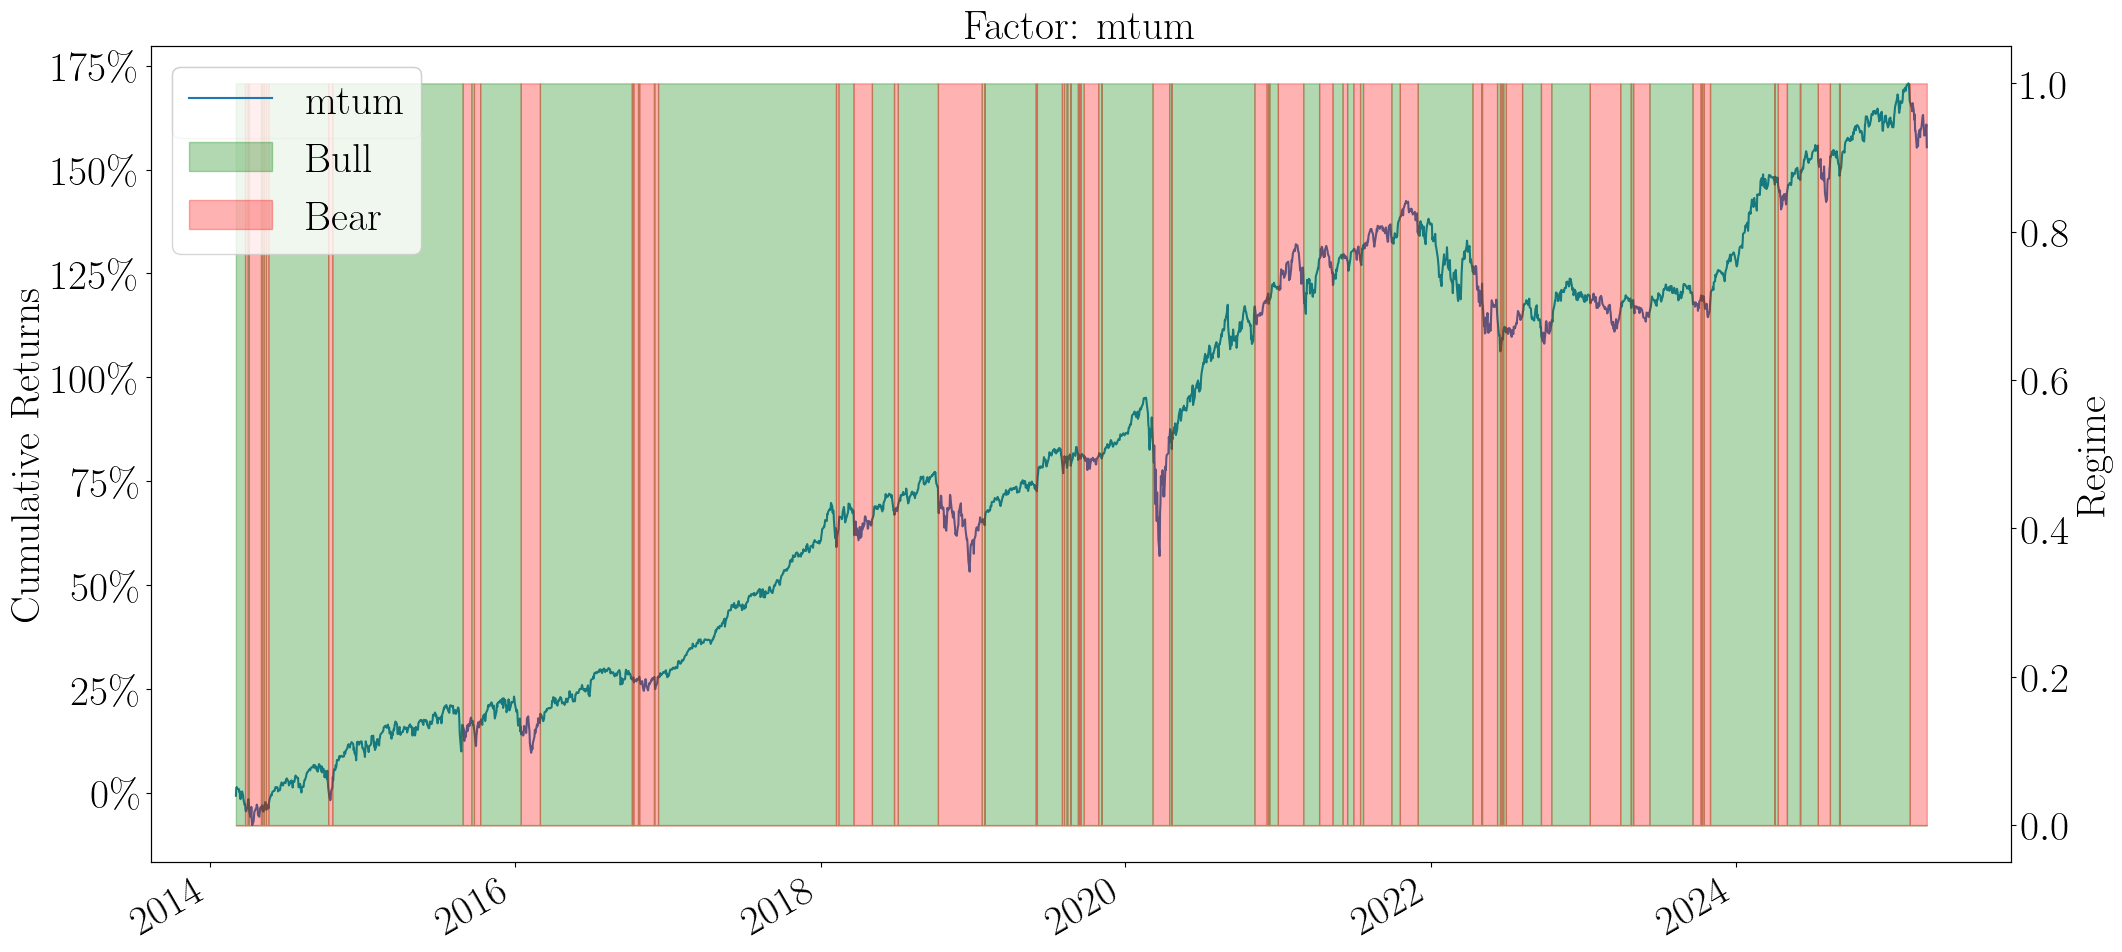

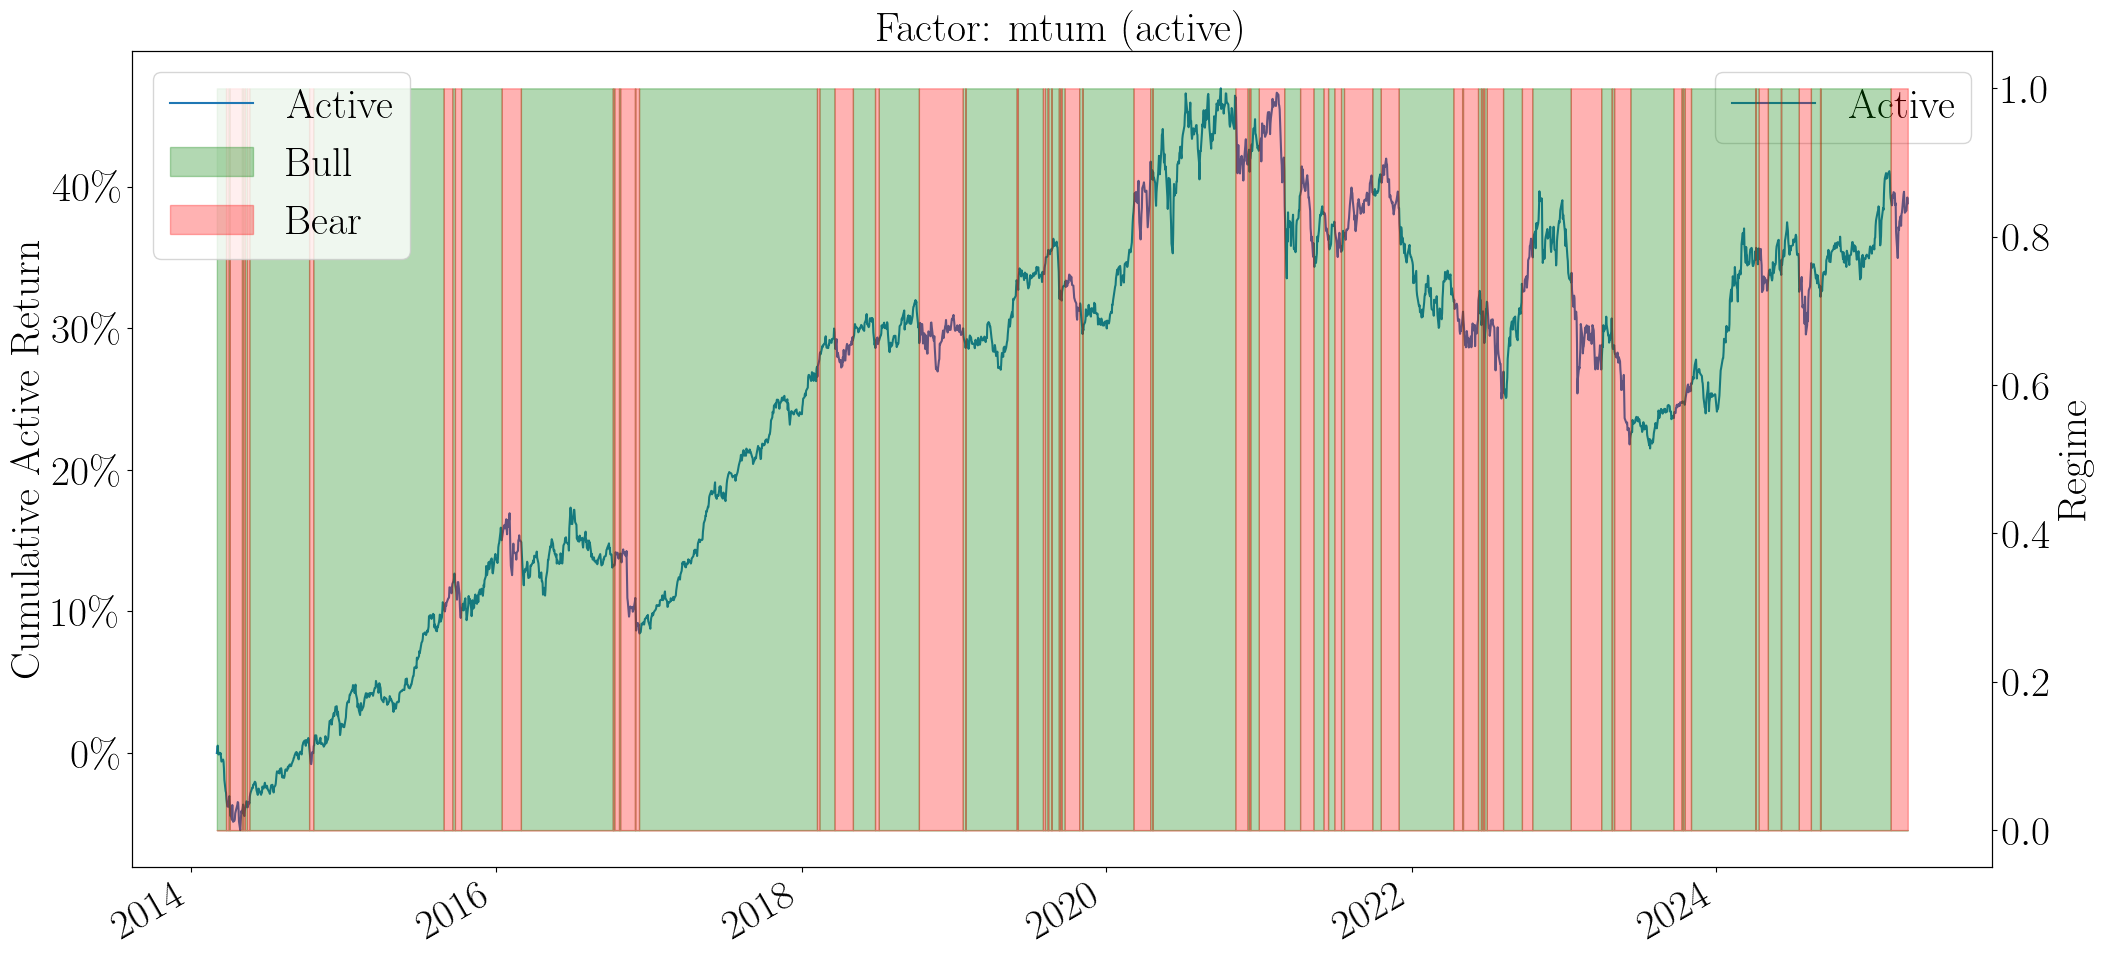

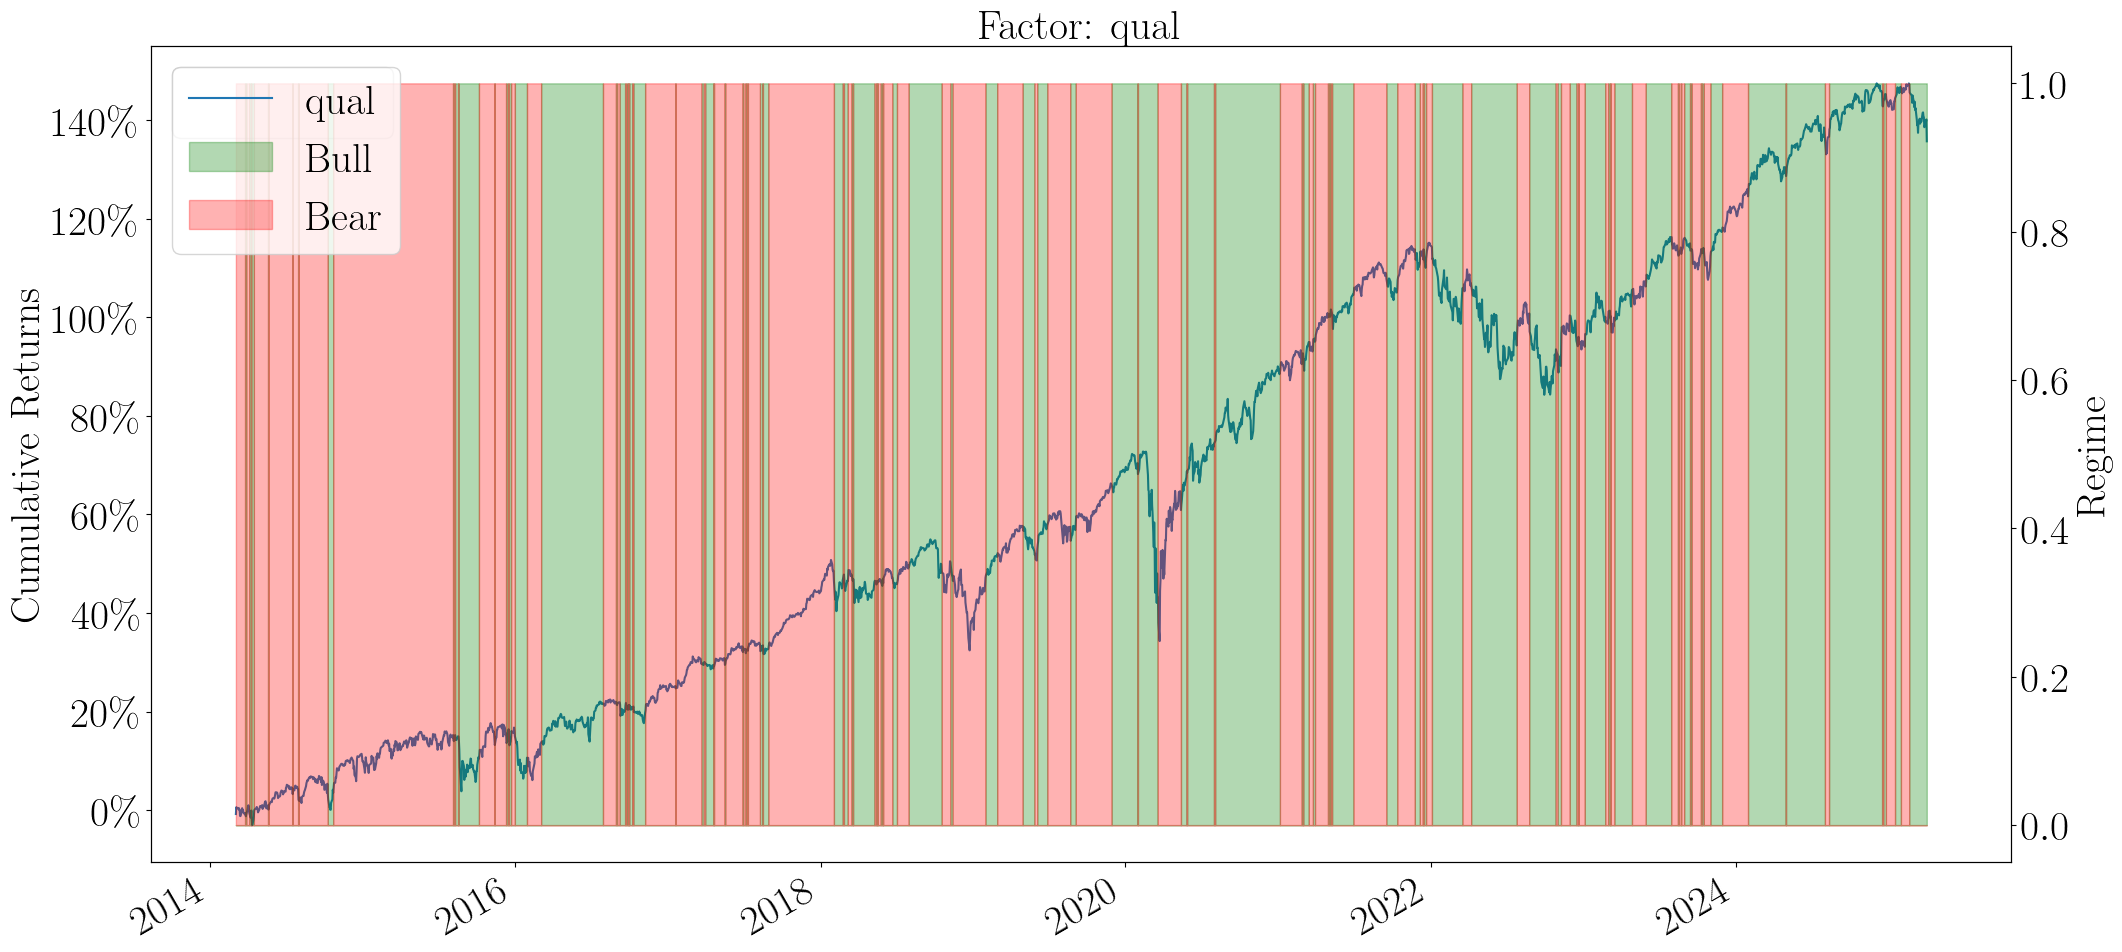

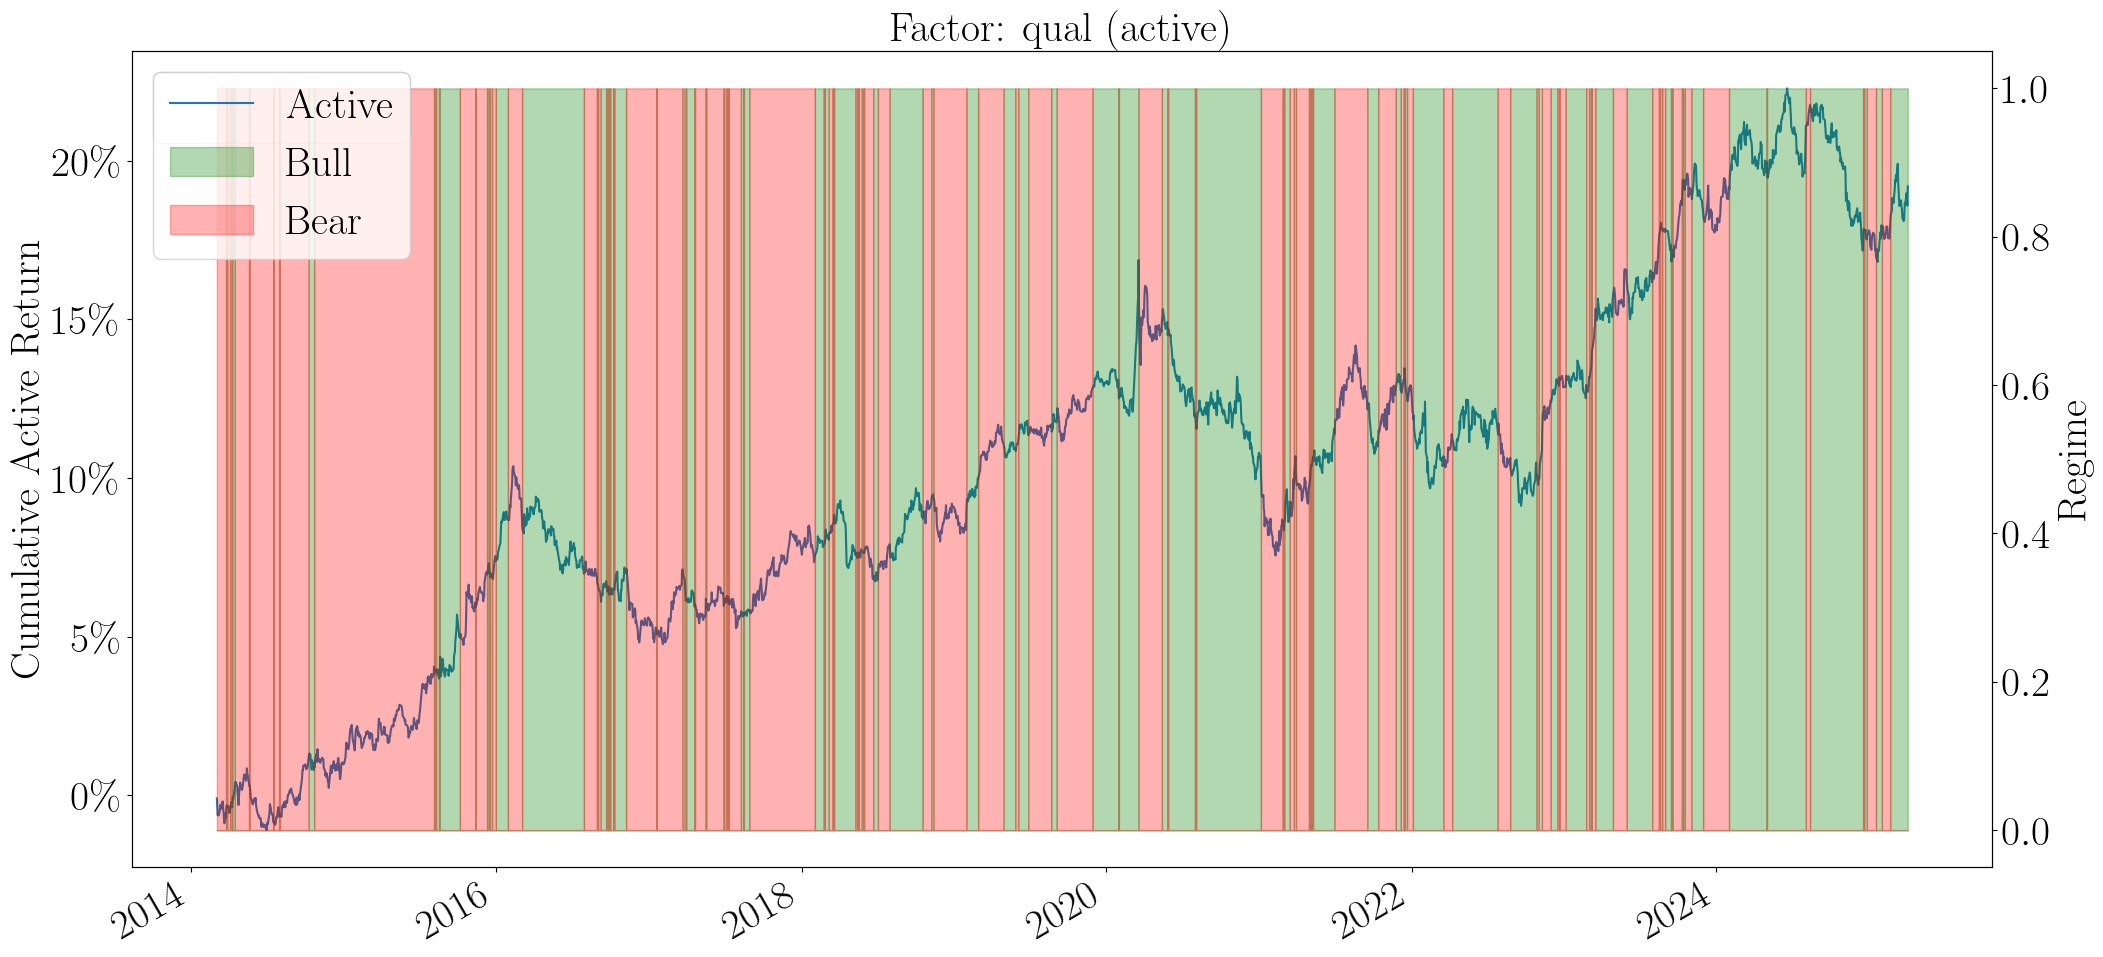

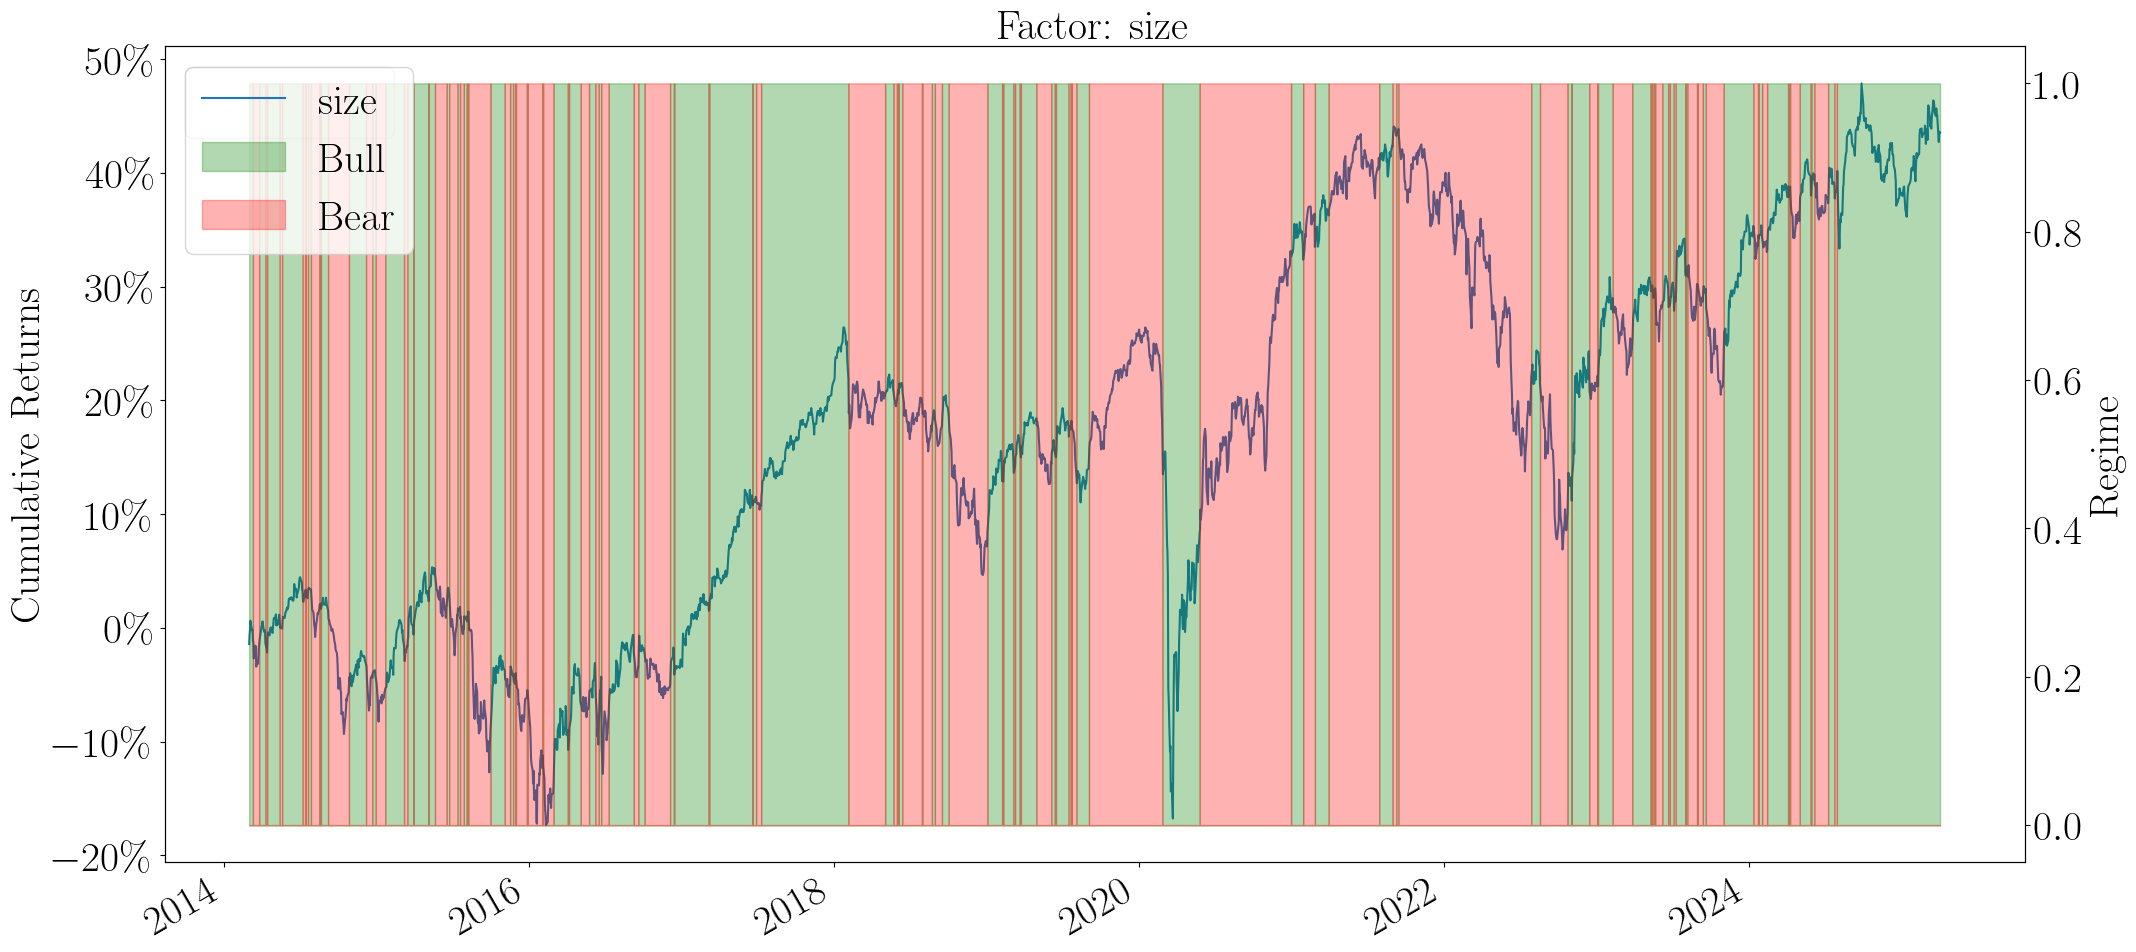

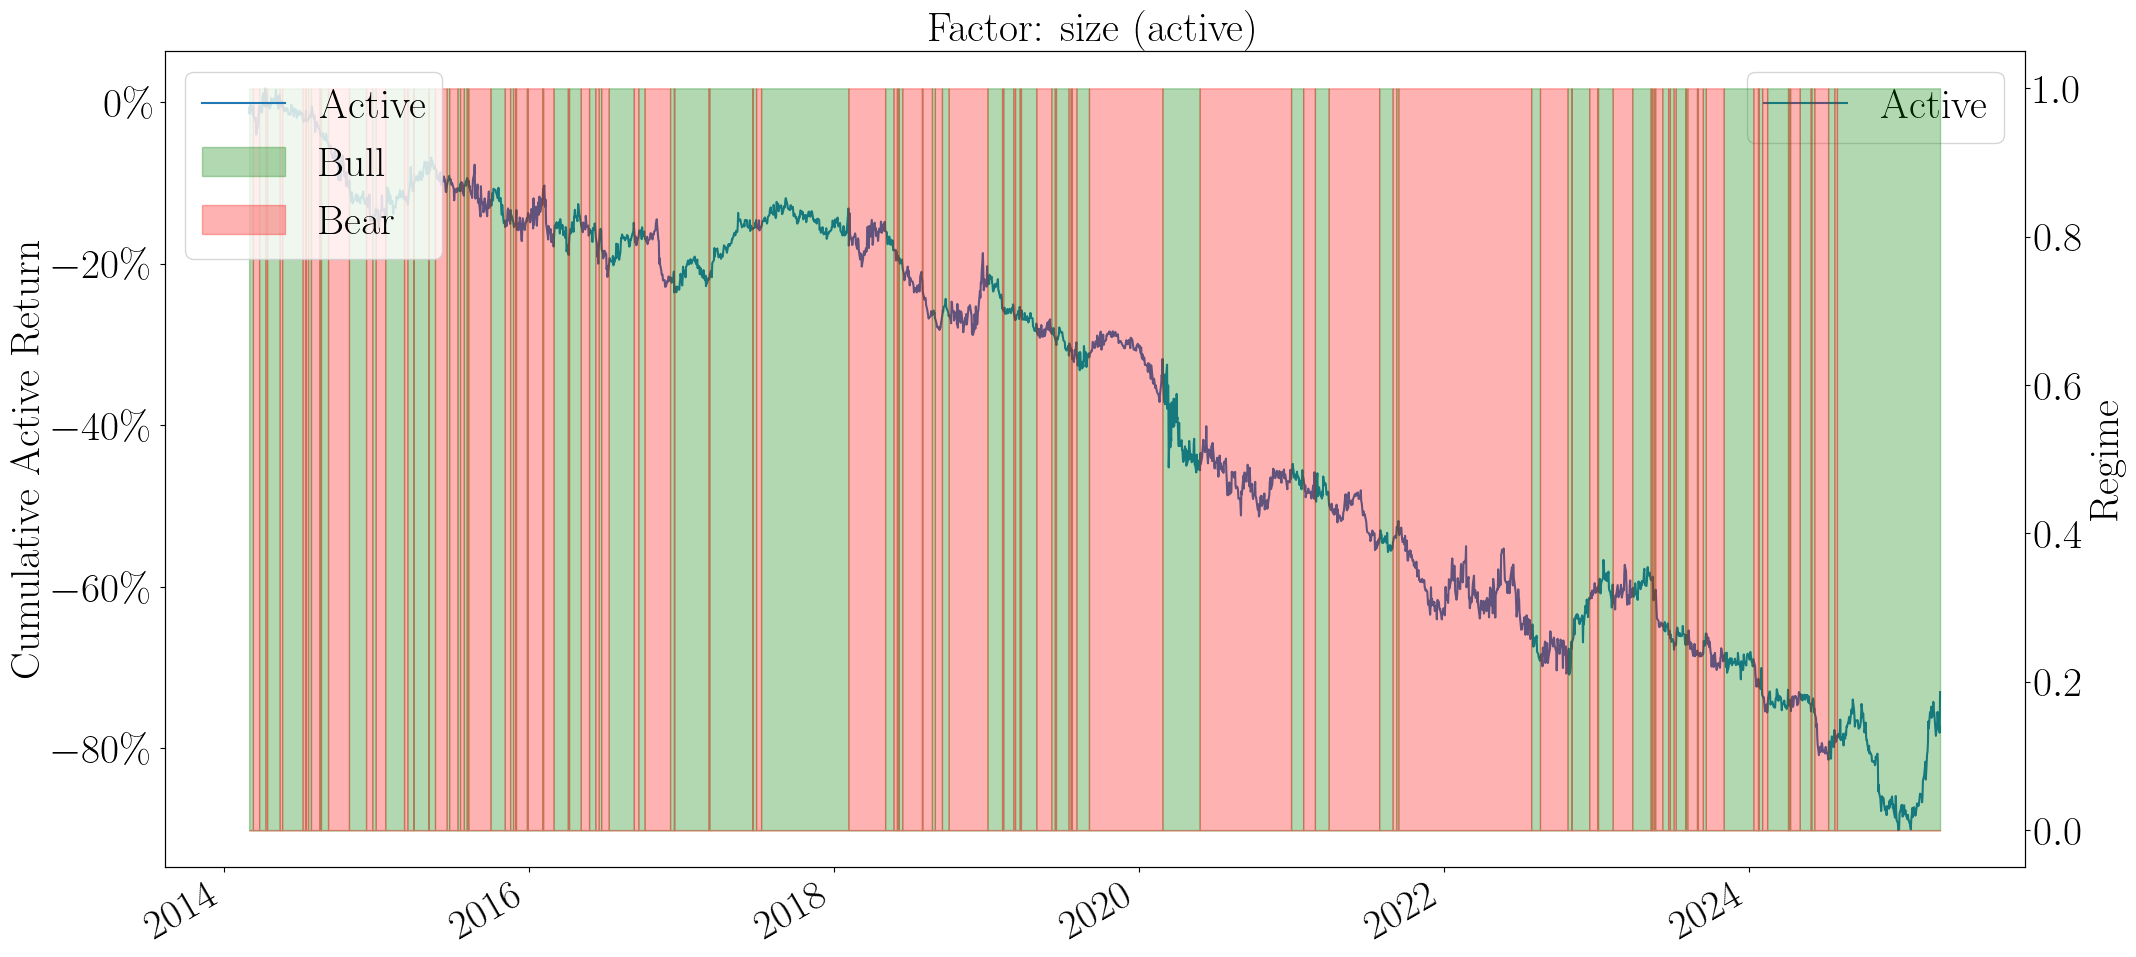

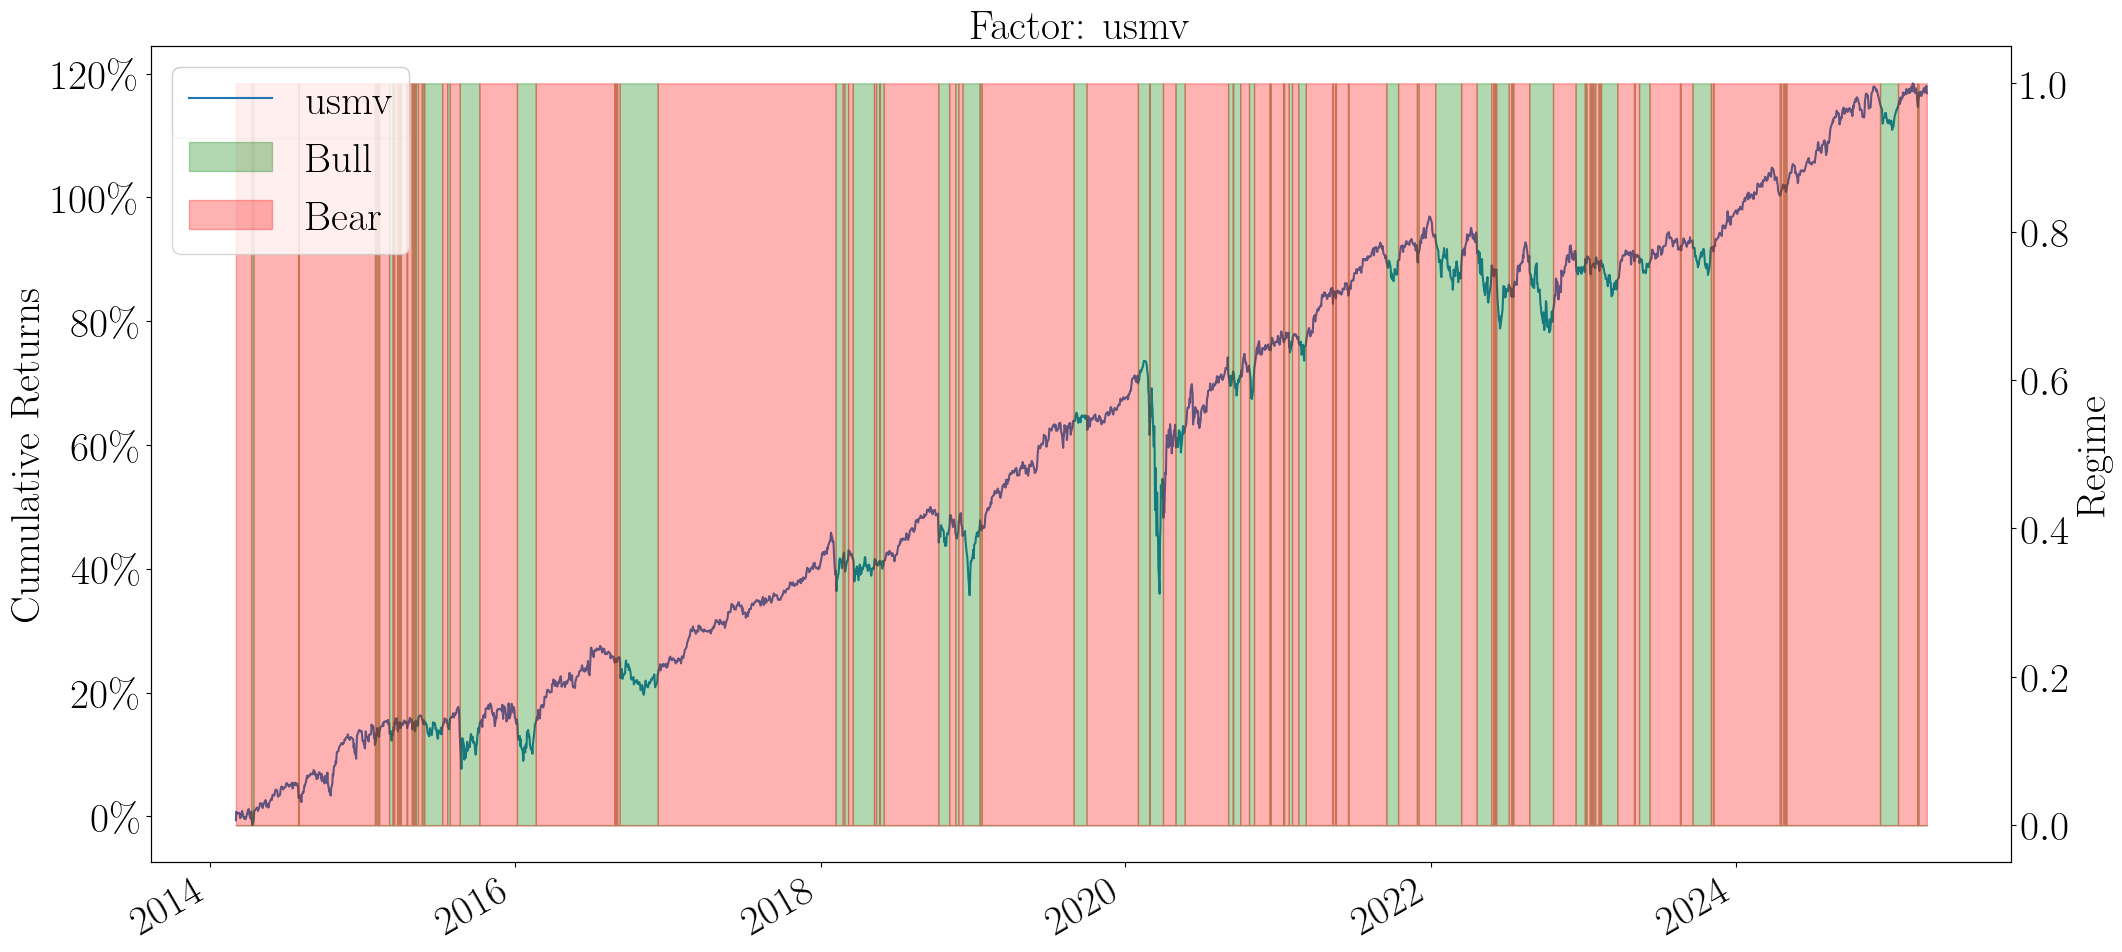

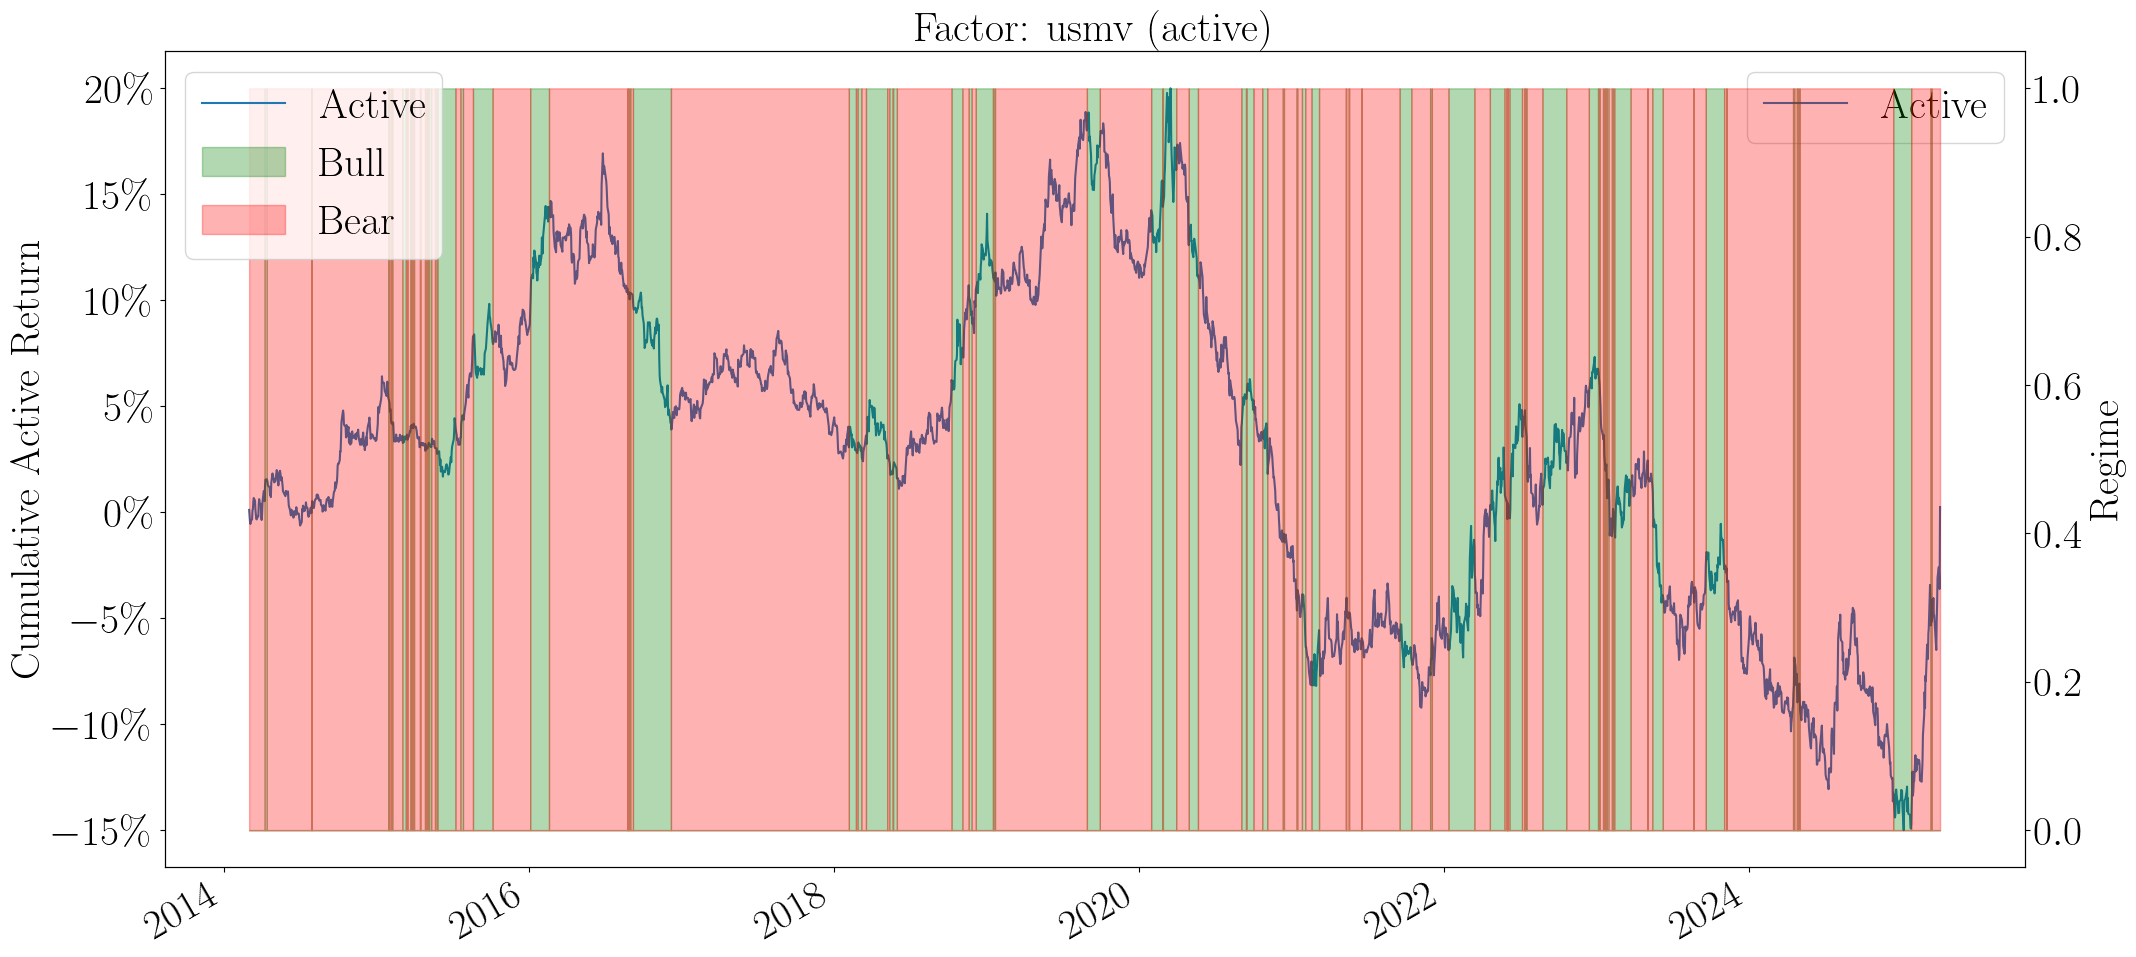

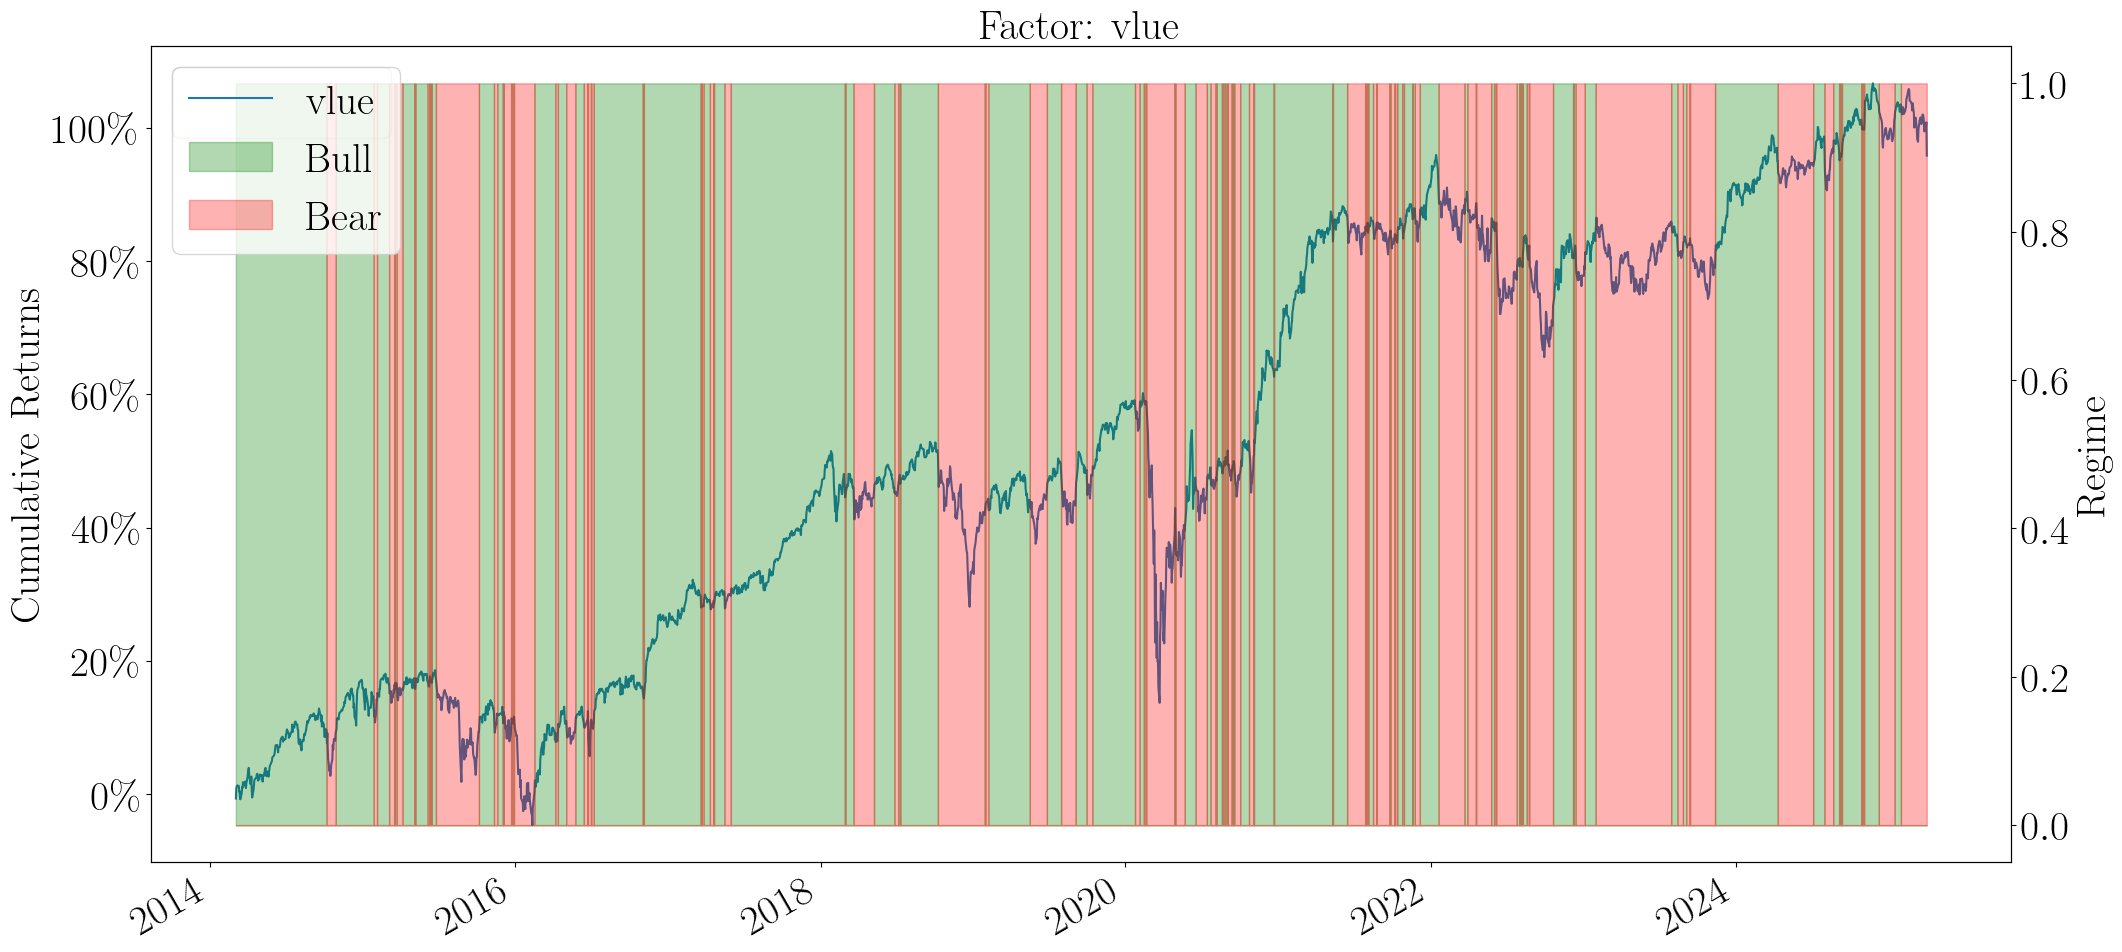

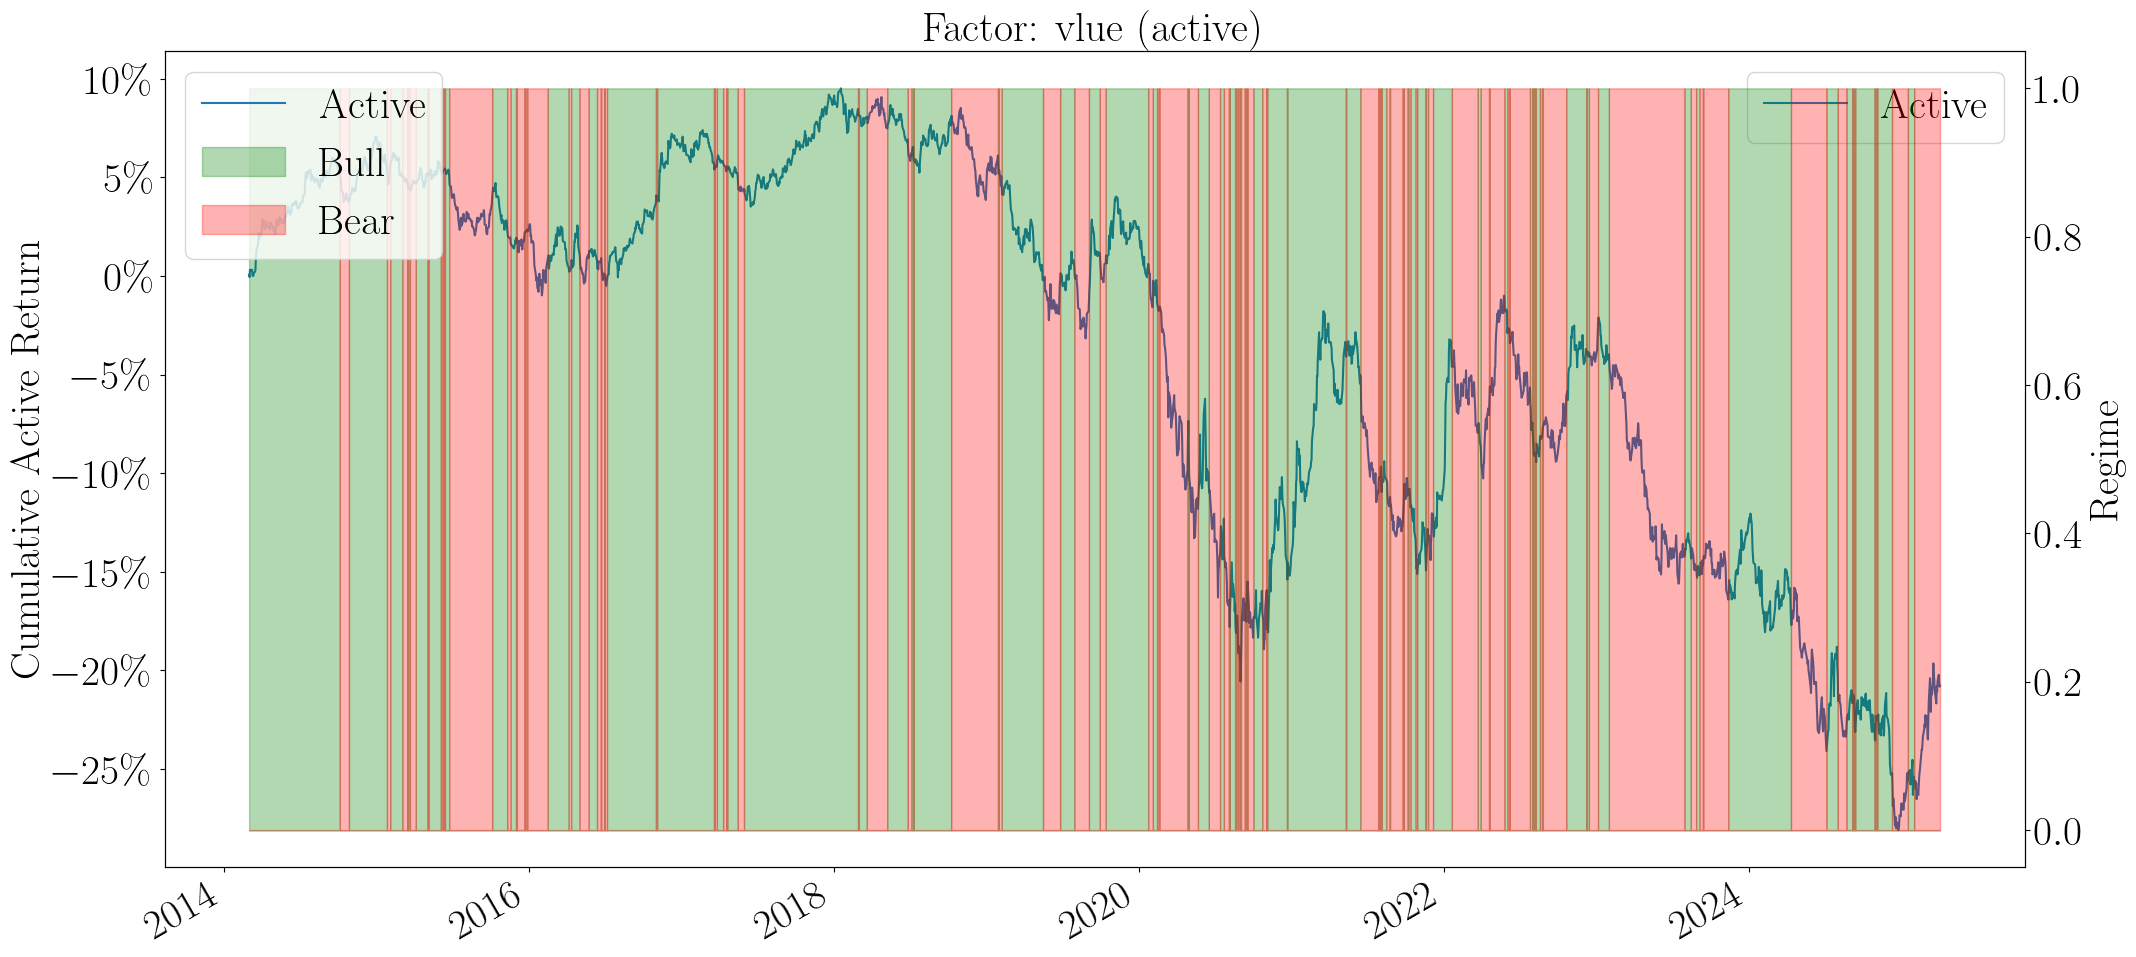

In [19]:
import matplotlib.pyplot as plt
from jumpmodels.plot import plot_regimes_and_cumret

for fac in factors:
    regimes     = factor_views[fac]["state"].dropna().astype(int)
    ret_raw     = factor_data_dict[fac]["fac_ret"].dropna()
    ret_active  = factor_data_dict[fac]["active_ret"].dropna()

    idx_raw    = regimes.index.intersection(ret_raw.index)
    idx_active = regimes.index.intersection(ret_active.index)

    # ---------- raw factor return ----------
    ax_raw, _ = plot_regimes_and_cumret(
        regimes.loc[idx_raw],
        ret_raw.loc[idx_raw],
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        legend_loc='upper left'
    )
    ax_raw.set_title(f"Factor: {fac}")
    plt.show()

    # ---------- active return ----------
    ax_act, _ = plot_regimes_and_cumret(
        regimes.loc[idx_active],
        ret_active.loc[idx_active].to_frame("Active"),
        n_c=2,
        colors_regimes=['g','r'],
        labels_regimes=['Bull','Bear'],
        ylabel_ret="Cumulative Active Return",
        legend_loc='upper left'
    )
    ax_act.set_title(f"Factor: {fac} (active)")
    plt.show()

    
